# Прогнозирование временных рядов методами машинного обучения

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-poster')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, confusion_matrix, mean_squared_error

plt.style.use('seaborn-poster')
import warnings
warnings.filterwarnings("ignore")

In [3]:
def trajectory_matrix(vector, L):
    K = len(vector)-L+1
    for k in range(K):
        if k == 0:
            tr_m = vector[k:k+L].reshape(L,1)
        else:
            tr_m = np.hstack((tr_m,vector[k:k+L].reshape(L,1)))
    return(tr_m)

## Сгенерируем 5 наборов рядов

1. Броуновское движение
2. Линейный тренд
3. Линейный тренд с броуновским движением
4. Линейный тренд с изломами
5. Линейный тренд с изломами и с броуновским движением

В каждый набор входит 100 рядов по 1000 точек каждый.

Модель броуновского движения:
$$ \xi_{n+1} = \xi_n + \epsilon_{n+1}, $$
где $ \epsilon_0, \epsilon_1, \epsilon_2 ,..., \sim N(\mu,\sigma^2)$.<br>
Параметры броуновского движения $\mu=0$, $\sigma^2=1$.

Модель линейного тренда:
$$ T_{n} = an, $$
где $a \sim N(\mu_a,\sigma_a^2)$ --- угол наклона тренда.<br>
Параметры линейного тренда $\mu_a = 0, \sigma_a^2 = 0.25$

Модель изломой в линейном тренде. Время между изломами имеет экспоненциальное распределение:
$$ \tau \sim Exp(\lambda), $$
где $\lambda$ --- среднее число изломов в единицу времени.<br>
Параметр излома $\lambda = \frac{1}{200}$, то есть в среднем излом происходит один раз в 200 точек, то есть на один временной ряд в среднем приходится 5 изломов.

В случае броуновского движения наилучшим возможным прогнозом будет предыдущее значение. И минимальная возможная ошибка $e^2 = \sigma^2 = 1$.

В случае линейного тренда без изломов лучшим прогнозом будет $t_n = t_{n-1} + (t_{n-1}-t_{n-2})$. Минимальная возможная ошибка в данном случае $e^2 = 0$.

В случае линейного тренда с броуновским движением лучшим прогнозом будет $t_n = t_{n-1} + \frac{\sum_{i=1}^{k}{d_i}}{k}$, где $d_i = t_i - t_{i-1},$ а $k$ --- параметр длины окна, который в данном случае равен максимальному. При этом минимальная ошибка должна быть $e^2 = \sigma^2 + \frac{\sigma_a^2}{k} = 1 + \frac{0.25}{k} = 1.0008 $.

В случае линейного тренда с изломами лучшим прогнозом будет $t_n = t_{n-1} + (t_{n-1}-t_{n-2})$, а ошибка будет $e^2 = \frac{2\sigma_a^2 \frac{n}{\lambda}}{n}$

Итого, в случае ряда с линейным трендом с изломами и броуновским движением ошибка нашего алгоритма должна попадать в диапазон: $$ \sigma^2 + \frac{\sigma_a^2}{k} \leq e \leq \sigma^2 + \sigma_a^2 + \frac{2\sigma_a^2 \frac{n}{\lambda}}{n}$$, то есть при наших параметрах $ 1.0025 \leq e \leq 1.2525$


, где $d_i = t_i - t_{i-1},$ а $k$ --- параметр длины окна, который нужно подбирать индивидуально для каждого ряда.

Взглянем на примеры рядов из каждого набора

In [4]:
df_wn = pd.read_csv('series1/white_noise.csv', sep=',', decimal='.')
df_lt = pd.read_csv('series1/linear_trend.csv', sep=',', decimal='.')
df_lt_wn = pd.read_csv('series1/trend_whiteNoise.csv', sep=',', decimal='.')
df_lt_d = pd.read_csv('series1/difficult_trend.csv', sep=',', decimal='.')
df_lt_d_wn = pd.read_csv('series1/difficultTrend_whiteNoise.csv', sep=',', decimal='.')


Броуновское движение

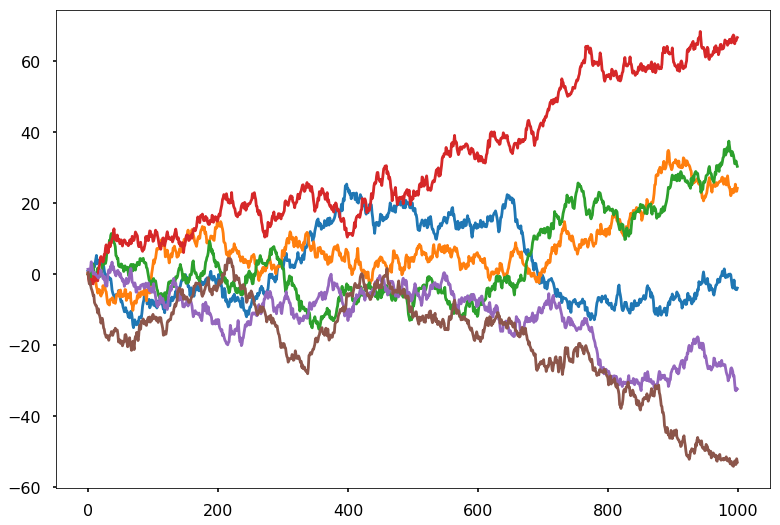

In [5]:
for i in range(1,7):
    plt.plot(df_wn['series'+str(i)])
plt.show()

Линейный тренд

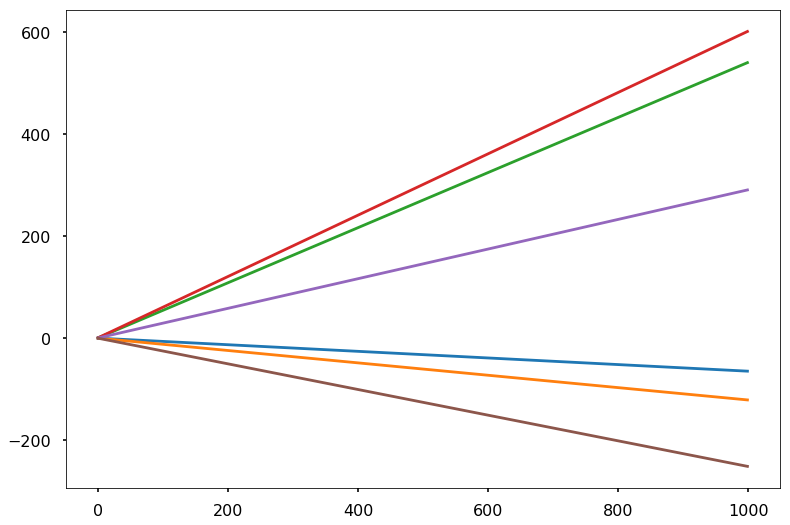

In [6]:
for i in range(1,7):
    plt.plot(df_lt['series'+str(i)])
plt.show()

Линейный тренд с броуновским движением

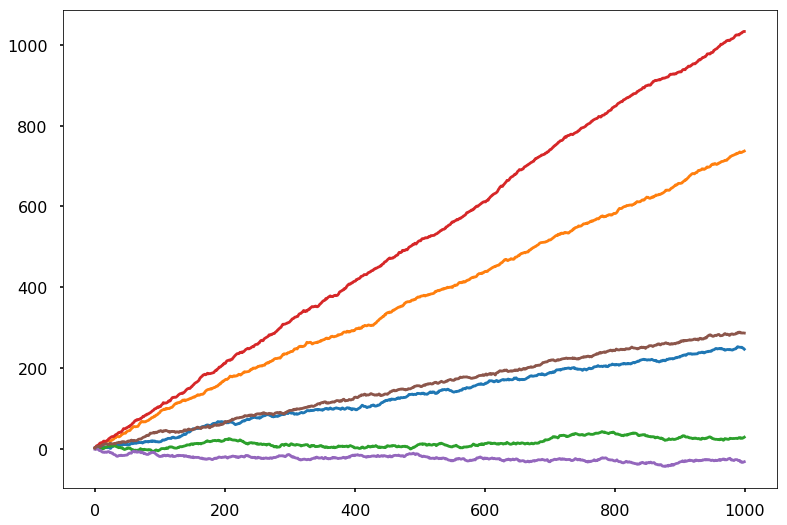

In [7]:
for i in range(1,7):
    plt.plot(df_lt_wn['series'+str(i)])
plt.show()

Линейный тренд с изломами

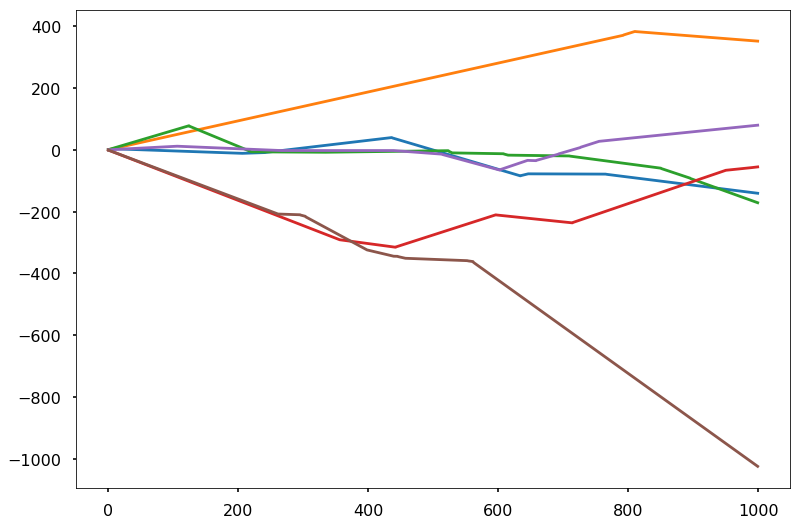

In [8]:
for i in range(1,7):
    plt.plot(df_lt_d['series'+str(i)])
plt.show()

Линейный тренд с броуновским движением и изломами

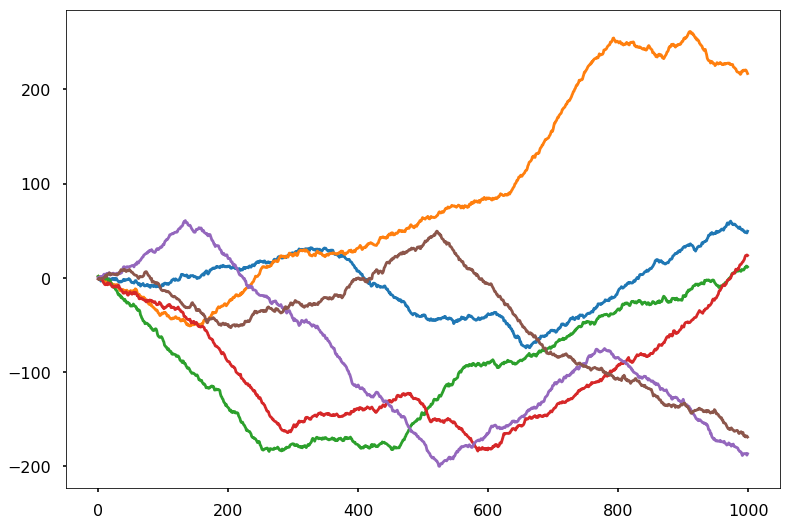

In [9]:
for i in range(1,7):
    plt.plot(df_lt_d_wn['series'+str(i)])
plt.show()

Для прогнозирования мы будем строить для каждого ряда тракеторную матрицу размерностью 700x301. Подразумевая, что каждая строчка это наблюдение (ряд), а столбцы это признаки. Предсказывать будем последний столбец траекторной матрицы, а разделение на тренировочную и тестовую выборки будем делать без перемешивания, оставляя 300 последних наблюдений на тест.

Создадим таблицу, куда будем записывать результаты

In [10]:
df_results = pd.DataFrame(
                columns = [
                    'Error low bound',
                    'Error high bound',
                    'Insight Test',
                    'Insight Test Confidence interval',
#                     'Insight 5% quantile',
#                     'Insight 95% quantile',
                    'Random forest Train',
                    'Random forest Test',
                    'Random forest Confidence interval'
#                     'Random forest Test 5% quantile',
#                     'Random forest Test 95% quantile'
                ]
            )

df_results.loc['Brownian','Error low bound'] = 1
df_results.loc['Brownian','Error high bound'] = 1
df_results.loc['Linear trend','Error low bound'] = 0
df_results.loc['Linear trend','Error high bound'] = 0.25
df_results.loc['Linear trend + Brownian','Error low bound'] = 1
df_results.loc['Linear trend + Brownian','Error high bound'] = 1.25
df_results.loc['Linear trend + changes','Error low bound'] = 0.0025
df_results.loc['Linear trend + changes','Error high bound'] = 0.2525
df_results.loc['Linear trend + changes + Brownian','Error low bound'] = 1.0025
df_results.loc['Linear trend + changes + Brownian','Error high bound'] = 1.2525

df_results

,Error low bound,Error high bound,Insight Test,Insight Test Confidence interval,Random forest Train,Random forest Test,Random forest Confidence interval
Brownian,1,1,NaN,NaN,NaN,NaN,NaN
Linear trend,0,0.25,NaN,NaN,NaN,NaN,NaN
Linear trend + Brownian,1,1.25,NaN,NaN,NaN,NaN,NaN
Linear trend + changes,0.0025,0.2525,NaN,NaN,NaN,NaN,NaN
Linear trend + changes + Brownian,1.0025,1.2525,NaN,NaN,NaN,NaN,NaN


## Построим предсказания инсайт моделями

### Броуновское движение

MSE for one series: 0.903700843953309


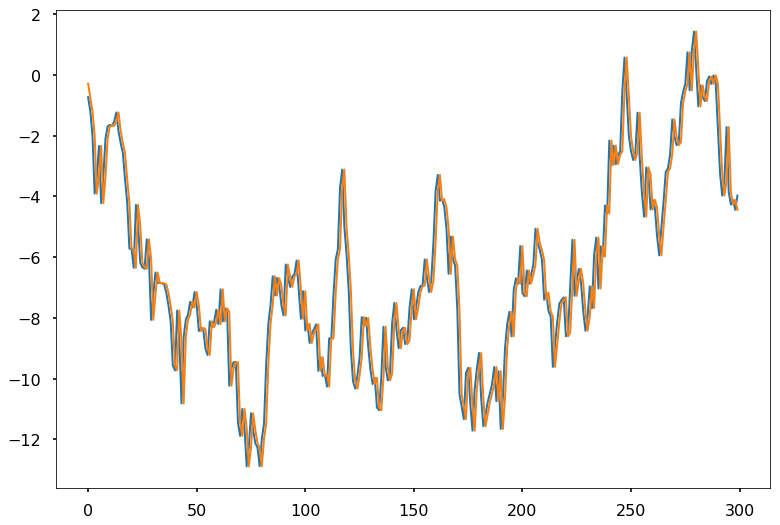

In [11]:
matrix = trajectory_matrix(df_wn['series1'], 700)

X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                    matrix[:,-1:], 
                                                    test_size=300, 
                                                    random_state=42,
                                                    shuffle=False
                                                   )

insight_prediction = X_test[:,-1:]
print('MSE for one series: {}'.format(mean_squared_error(y_test, insight_prediction)))

plt.plot(y_test, linewidth=2)
plt.plot(insight_prediction, linewidth=2)
plt.show()

Average MSE for 100 series: 1.0107 
Confidence interval = 0.0179


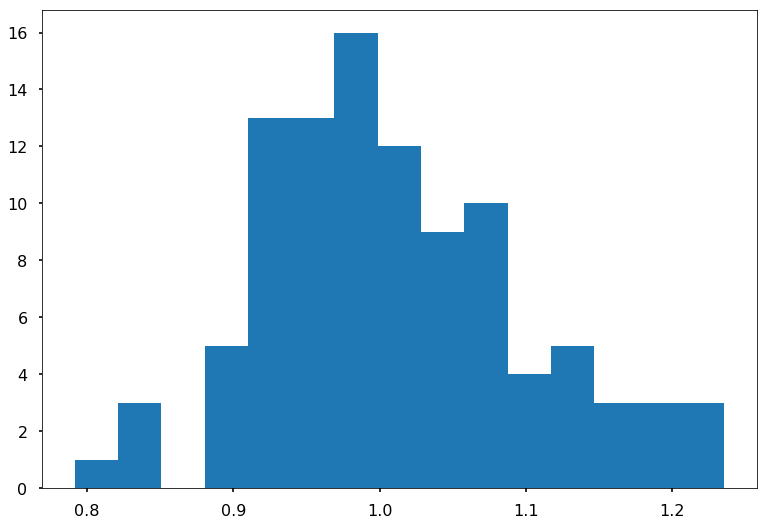

In [12]:
mse_list = []
for i in range(1,101):
    matrix = trajectory_matrix(df_wn['series' + str(i)], 700)

    X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                        matrix[:,-1:], 
                                                        test_size=300, 
                                                        random_state=42,
                                                        shuffle=False
                                                       )

    insight_prediction = X_test[:,-1:]
    mse_list.append(mean_squared_error(y_test, insight_prediction))


# print('Average MSE for 100 series: {:.4f}'.format(np.mean(mse_list)))
# print('Average MSE for 100 series: {:.4f} \n5% quantile = {:.4f} 95% quantile = {:.4f}'.format(np.mean(mse_list),
#                                                                                    np.quantile(mse_list, 0.05),
#                                                                                    np.quantile(mse_list, 0.95)))

print('Average MSE for 100 series: {:.4f} \nConfidence interval = {:.4f}'.format(np.mean(mse_list),
                                                                                   2*np.std(mse_list)/10))
plt.hist(mse_list, bins=15)
plt.show()

df_results.loc['Brownian','Insight Test'] = round(np.mean(mse_list),4)
df_results.loc['Brownian','Insight Test Confidence interval'] = round(2*np.std(mse_list)/10,4)
# df_results.loc['Brownian','Insight 5% quantile'] = round(np.quantile(mse_list, 0.05),4)
# df_results.loc['Brownian','Insight 95% quantile'] = round(np.quantile(mse_list, 0.95),4)


### Линейный тренд

MSE for one series: 0.0000


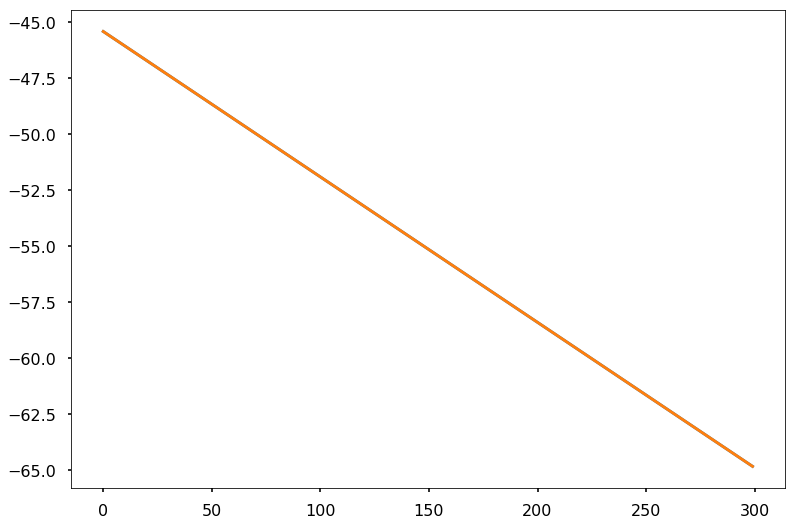

In [13]:
matrix = trajectory_matrix(df_lt['series1'], 700)

X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                    matrix[:,-1:], 
                                                    test_size=300, 
                                                    random_state=42,
                                                    shuffle=False
                                                   )

insight_prediction = X_test[:,-1:] + (X_test[:,-1:]-X_test[:,-2:-1])
print('MSE for one series: {:.4f}'.format(mean_squared_error(y_test, insight_prediction)))

plt.plot(y_test)
plt.plot(insight_prediction)
plt.show()

Average MSE for 100 series: 0.0000 
Confidence interval = 0.0000


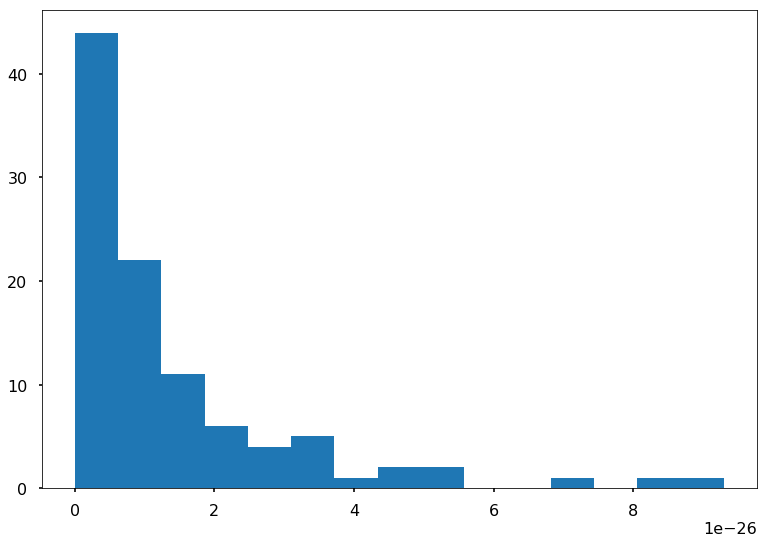

In [14]:
mse_list = []
for i in range(1,101):
    matrix = trajectory_matrix(df_lt['series' + str(i)], 700)

    X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                        matrix[:,-1:], 
                                                        test_size=300, 
                                                        random_state=42,
                                                        shuffle=False
                                                       )

    insight_prediction = X_test[:,-1:] + (X_test[:,-1:]-X_test[:,-2:-1])
    mse_list.append(mean_squared_error(y_test, insight_prediction))


# print('Average MSE for 100 series: {:.4f}'.format(np.mean(mse_list)))
# print('Average MSE for 100 series: {:.4f} \n5% quantile = {:.4f} 95% quantile = {:.4f}'.format(np.mean(mse_list),
#                                                                                    np.quantile(mse_list, 0.05),
#                                                                                    np.quantile(mse_list, 0.95)))

print('Average MSE for 100 series: {:.4f} \nConfidence interval = {:.4f}'.format(np.mean(mse_list),
                                                                                   2*np.std(mse_list)/10))
plt.hist(mse_list, bins=15)
plt.show()

df_results.loc['Linear trend','Insight Test'] = round(np.mean(mse_list),4)
df_results.loc['Linear trend','Insight Test Confidence interval'] = round(2*np.std(mse_list)/10,4)
# df_results.loc['Linear trend','Insight 5% quantile'] = round(np.quantile(mse_list, 0.05),4)
# df_results.loc['Linear trend','Insight 95% quantile'] = round(np.quantile(mse_list, 0.95),4)

### Линейный тренд с броуновским движением

MSE for one series: 0.8423


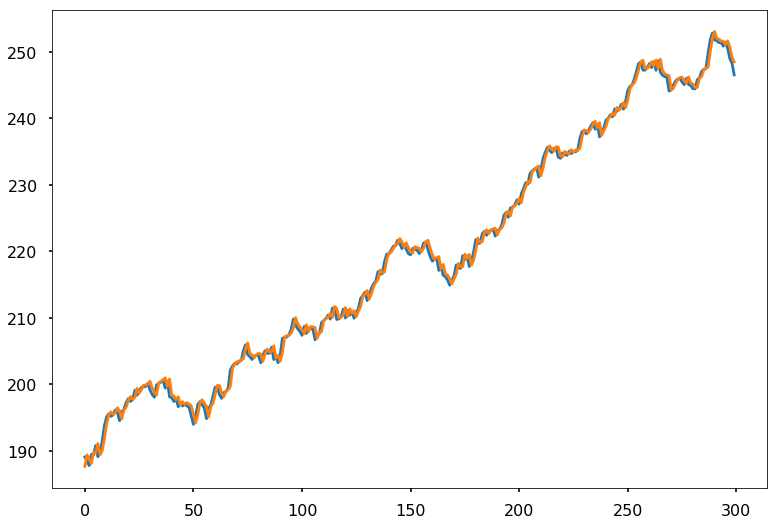

In [15]:
matrix = trajectory_matrix(df_lt_wn['series1'], 700)

X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                    matrix[:,-1:], 
                                                    test_size=300, 
                                                    random_state=42,
                                                    shuffle=False
                                                   )

insight_prediction = X_test[:,-1:] + np.mean(np.diff(X_test), axis=1).reshape(-1,1)
print('MSE for one series: {:.4f}'.format(mean_squared_error(y_test, insight_prediction)))

plt.plot(y_test)
plt.plot(insight_prediction)
plt.show()

Average MSE for 100 series: 1.0135 
Confidence interval = 0.0176


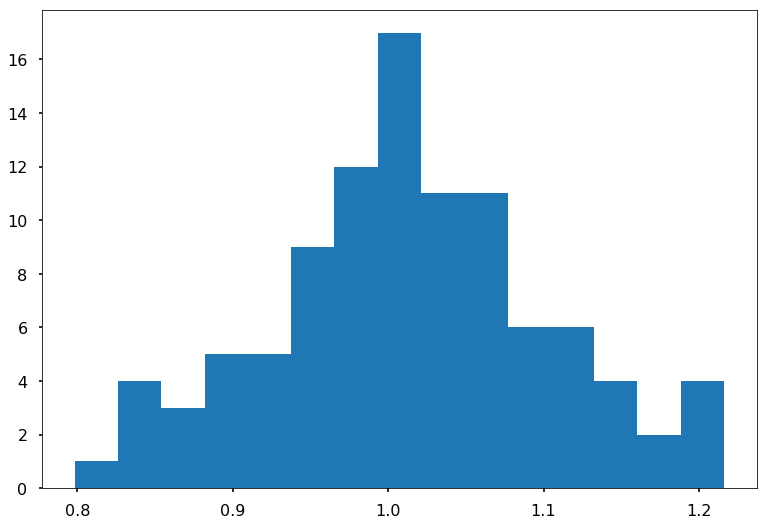

In [16]:
mse_list = []
for i in range(1,101):
    matrix = trajectory_matrix(df_lt_wn['series' + str(i)], 700)

    X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                        matrix[:,-1:], 
                                                        test_size=300, 
                                                        random_state=42,
                                                        shuffle=False
                                                       )

    insight_prediction = X_test[:,-1:] + np.mean(np.diff(X_test),axis=1).reshape(-1,1)
    mse_list.append(mean_squared_error(y_test, insight_prediction))


# print('Average MSE for 100 series: {:.4f}'.format(np.mean(mse_list)))
# print('Average MSE for 100 series: {:.4f} \n5% quantile = {:.4f} 95% quantile = {:.4f}'.format(np.mean(mse_list),
#                                                                                    np.quantile(mse_list, 0.05),
#                                                                                    np.quantile(mse_list, 0.95)))


print('Average MSE for 100 series: {:.4f} \nConfidence interval = {:.4f}'.format(np.mean(mse_list),
                                                                                   2*np.std(mse_list)/10))

plt.hist(mse_list, bins=15)
plt.show()

df_results.loc['Linear trend + Brownian','Insight Test'] = round(np.mean(mse_list),4)
df_results.loc['Linear trend + Brownian','Insight Test Confidence interval'] = round(2*np.std(mse_list)/10,4)
# df_results.loc['Linear trend + Brownian','Insight 5% quantile'] = round(np.quantile(mse_list, 0.05),4)
# df_results.loc['Linear trend + Brownian','Insight 95% quantile'] = round(np.quantile(mse_list, 0.95),4)

### Линейный тренд с изломами

Сначала подберем оптимальную длину окна $k$ на тренировочном наборе (для каждого ряда подбирается своя длина окна).

In [17]:
def get_k_optimals(keys, mse_l):
    res_l = []
    for j in mse_l:
        for counter, i in enumerate(j):
            if i == min(j):
                res_l.append(keys[counter])
                break
    return(res_l)

Optimal k is 2


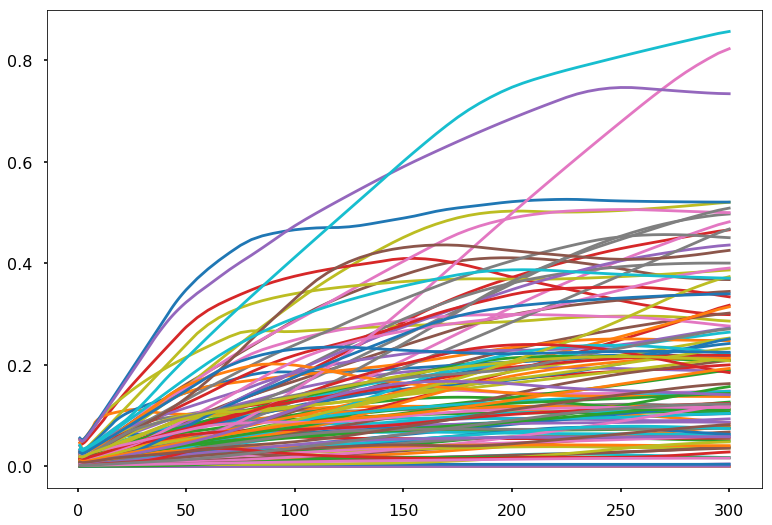

CPU times: user 14.8 s, sys: 9.77 s, total: 24.6 s
Wall time: 24.9 s


In [18]:
%%time
k_list = [i for i in range(1,50)]
k_list.extend([i for i in range(50, 301, 5)])
mse_list_all = []


for i in range(1,101):
    mse_list = []
    matrix = trajectory_matrix(df_lt_d['series' + str(i)], 700)

    X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                        matrix[:,-1:], 
                                                        test_size=300, 
                                                        random_state=42,
                                                        shuffle=False
                                                       )
    for k in k_list:
        insight_prediction = X_train[:,-1:] + np.mean(np.diff(X_train)[:,-k:], axis=1).reshape(-1,1)
        mse_list.append(mean_squared_error(y_train, insight_prediction))
        
    mse_list_all.append(mse_list)

# k_optimals = [k_list[counter] for j in mse_list_all for counter, i in enumerate(j) if i == min(j)]
k_optimals = get_k_optimals(k_list, mse_list_all)

print('Optimal k is {}'.format(max(set(k_optimals), key = k_optimals.count)

))
for pl in mse_list_all:
    plt.plot(k_list, pl)
plt.show()

MSE for one series: 0.0010


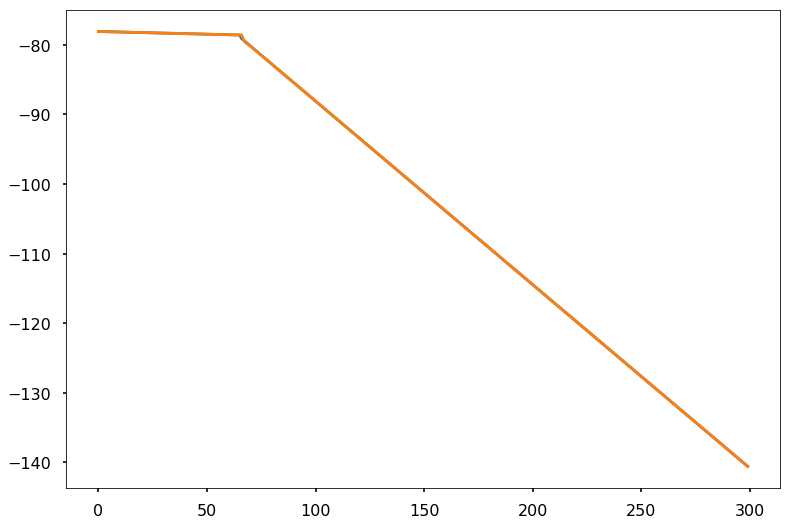

In [19]:
matrix = trajectory_matrix(df_lt_d['series1'], 700)
k = k_optimals[0]

X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                    matrix[:,-1:], 
                                                    test_size=300, 
                                                    random_state=42,
                                                    shuffle=False
                                                   )

insight_prediction = X_test[:,-1:] + np.mean(np.diff(X_test)[:,-k:], axis=1).reshape(-1,1)
print('MSE for one series: {:.4f}'.format(mean_squared_error(y_test, insight_prediction)))

plt.plot(y_test)
plt.plot(insight_prediction)
plt.show()

Average MSE for 100 series: 0.0093 
Confidence interval = 0.0024


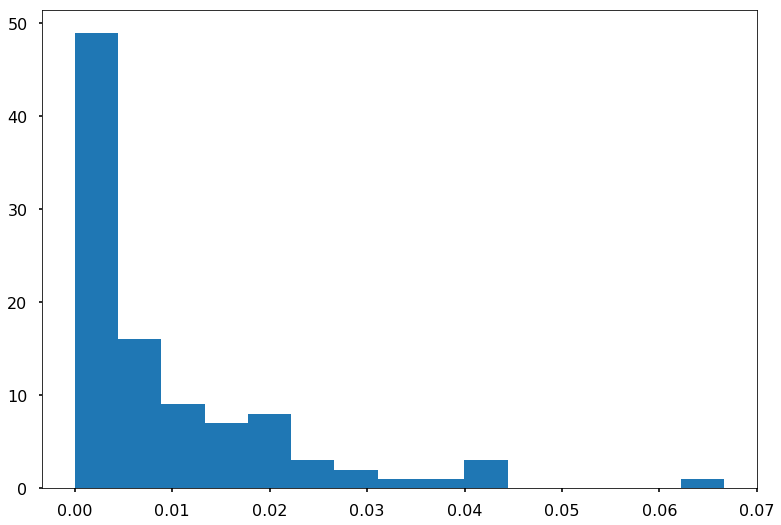

In [20]:
mse_list = []
# k = 2

for i in range(1,101):
    k = k_optimals[i-1]
    matrix = trajectory_matrix(df_lt_d['series' + str(i)], 700)

    X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                        matrix[:,-1:], 
                                                        test_size=300, 
                                                        random_state=42,
                                                        shuffle=False
                                                       )

    insight_prediction = X_test[:,-1:] + np.mean(np.diff(X_test)[:,-k:],axis=1).reshape(-1,1)
    mse_list.append(mean_squared_error(y_test, insight_prediction))


# print('Average MSE for 100 series: {:.4f} \n5% quantile = {:.4f} 95% quantile = {:.4f}'.format(np.mean(mse_list),
#                                                                                    np.quantile(mse_list, 0.05),
#                                                                                    np.quantile(mse_list, 0.95)))
print('Average MSE for 100 series: {:.4f} \nConfidence interval = {:.4f}'.format(np.mean(mse_list),
                                                                                   2*np.std(mse_list)/10))
# 2*np.std(mse_list)/10
plt.hist(mse_list, bins=15)
plt.show()

df_results.loc['Linear trend + changes','Insight Test'] = round(np.mean(mse_list),4)
df_results.loc['Linear trend + changes','Insight Test Confidence interval'] = round(2*np.std(mse_list)/10,4)
# df_results.loc['Linear trend + changes','Insight 5% quantile'] = round(np.quantile(mse_list, 0.05),4)
# df_results.loc['Linear trend + changes','Insight 95% quantile'] = round(np.quantile(mse_list, 0.95),4)

### Линейный тренд с изломами и броуновским движением

Снова подберем длину окна

Optimal k is 22


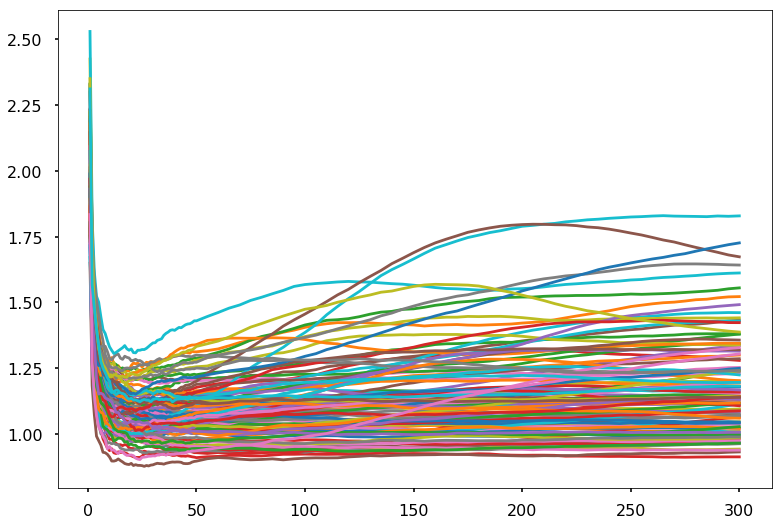

CPU times: user 14.7 s, sys: 9.68 s, total: 24.4 s
Wall time: 24.6 s


In [21]:
%%time
k_list = [i for i in range(1,50)]
k_list.extend([i for i in range(50, 301, 5)])
mse_list_all = []


for i in range(1,101):
    mse_list = []
    matrix = trajectory_matrix(df_lt_d_wn['series' + str(i)], 700)

    X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                        matrix[:,-1:], 
                                                        test_size=300, 
                                                        random_state=42,
                                                        shuffle=False
                                                       )
    for k in k_list:
        insight_prediction = X_train[:,-1:] + np.mean(np.diff(X_train)[:,-k:], axis=1).reshape(-1,1)
        mse_list.append(mean_squared_error(y_train, insight_prediction))
        
    mse_list_all.append(mse_list)

k_optimals = get_k_optimals(k_list, mse_list_all)

print('Optimal k is {}'.format(max(set(k_optimals), key = k_optimals.count)))

for pl in mse_list_all:
    plt.plot(k_list, pl)
plt.show()

Average MSE for 100 series: 1.1981 
Confidence interval = 0.0261


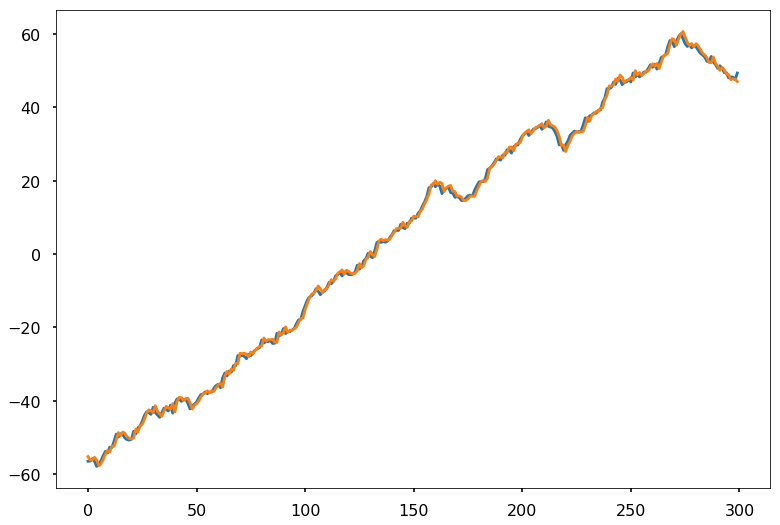

In [22]:
matrix = trajectory_matrix(df_lt_d_wn['series1'], 700)
# k = 33

k = k_optimals[0]
X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                    matrix[:,-1:], 
                                                    test_size=300, 
                                                    random_state=42,
                                                    shuffle=False
                                                   )

insight_prediction = X_test[:,-1:] + np.mean(np.diff(X_test)[:,-k:],axis=1).reshape(-1,1)
# print('MSE for one series: {:.4f}'.format(mean_squared_error(y_test, insight_prediction)))
# print('Average MSE for 100 series: {:.4f} \n5% quantile = {:.4f} 95% quantile = {:.4f}'.format(np.mean(mse_list),
#                                                                                    np.quantile(mse_list, 0.05),
#                                                                                    np.quantile(mse_list, 0.95)))
print('Average MSE for 100 series: {:.4f} \nConfidence interval = {:.4f}'.format(np.mean(mse_list),
                                                                                   2*np.std(mse_list)/10))

plt.plot(y_test)
plt.plot(insight_prediction)
plt.show()

Average MSE for 100 series: 1.0791 
Confidence interval = 0.0197


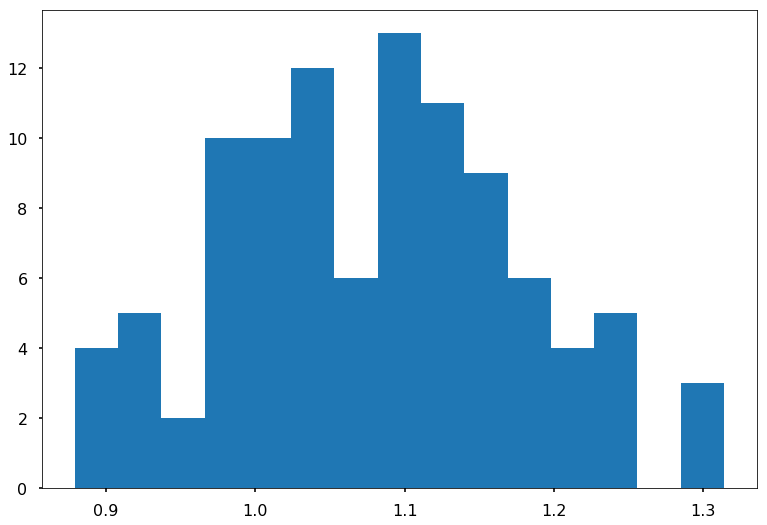

In [24]:
mse_list = []
# k = 33

for i in range(1,101):
    k = k_optimals[i-1]
    matrix = trajectory_matrix(df_lt_d_wn['series' + str(i)], 700)

    X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                        matrix[:,-1:], 
                                                        test_size=300, 
                                                        random_state=42,
                                                        shuffle=False
                                                       )

    insight_prediction = X_test[:,-1:] + np.mean(np.diff(X_test)[:,-k:],axis=1).reshape(-1,1)
    mse_list.append(mean_squared_error(y_test, insight_prediction))


# print('Average MSE for 100 series: {:.4f} \n5% quantile = {:.4f} 95% quantile = {:.4f}'.format(np.mean(mse_list),
#                                                                                    np.quantile(mse_list, 0.05),
#                                                                                    np.quantile(mse_list, 0.95)))
print('Average MSE for 100 series: {:.4f} \nConfidence interval = {:.4f}'.format(np.mean(mse_list),
                                                                                   2*np.std(mse_list)/10))
plt.hist(mse_list, bins=15)
plt.show()

df_results.loc['Linear trend + changes + Brownian','Insight Test'] = round(np.mean(mse_list),4)
df_results.loc['Linear trend + changes + Brownian','Insight Test Confidence interval'] = round(2*np.std(mse_list)/10,4)
# df_results.loc['Linear trend + changes + Brownian','Insight 5% quantile'] = round(np.quantile(mse_list, 0.05),4)
# df_results.loc['Linear trend + changes + Brownian','Insight 95% quantile'] = round(np.quantile(mse_list, 0.95),4)

## Применение Random Forest

### Броуновское движение

Броуновское движение random forest as is прогнозирует очень плохо

Train MSE: 0.5153 Test MSE: 77.9523


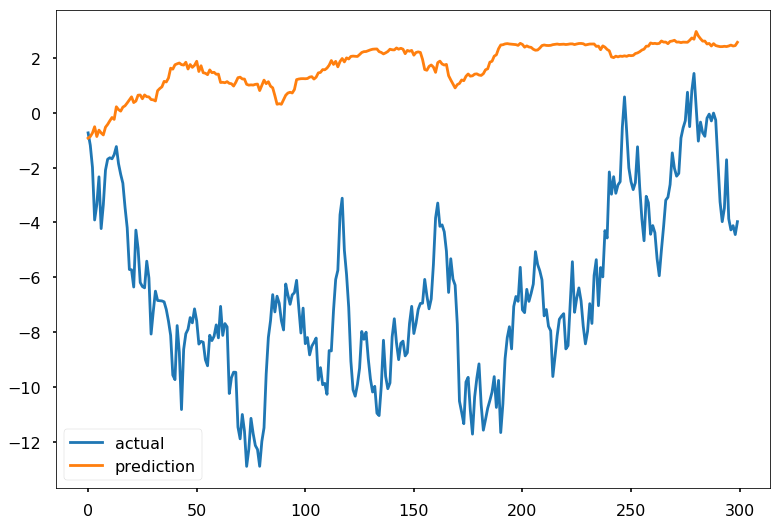

In [25]:
matrix = trajectory_matrix(df_wn['series1'], 700)

X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                    matrix[:,-1:], 
                                                    test_size=300, 
                                                    random_state=42,
                                                    shuffle=False
                                                   )

model_rf = RandomForestRegressor(max_depth = 5, n_estimators = 100)
model_rf.fit(X_train,y_train.reshape(-1,1))

train_prediction = model_rf.predict(X_train)
test_prediction = model_rf.predict(X_test)

mse_train = mean_squared_error(y_train, train_prediction)
mse_test = mean_squared_error(y_test, test_prediction)

print('Train MSE: {:.4f} Test MSE: {:.4f}'.format(round(mse_train,8),
                                          round(mse_test,8)))

plt.plot(y_test, label = 'actual')
plt.plot(test_prediction, label = 'prediction')
plt.legend()
plt.show()

Попробуем взять только последний элемент ряда. Результат лучше, но по-прежнему не имеет смысла. Очевидно алгоритм научился работать только с данными в определенном диапазоне.

Train MSE: 0.2156 Test MSE: 38.0873


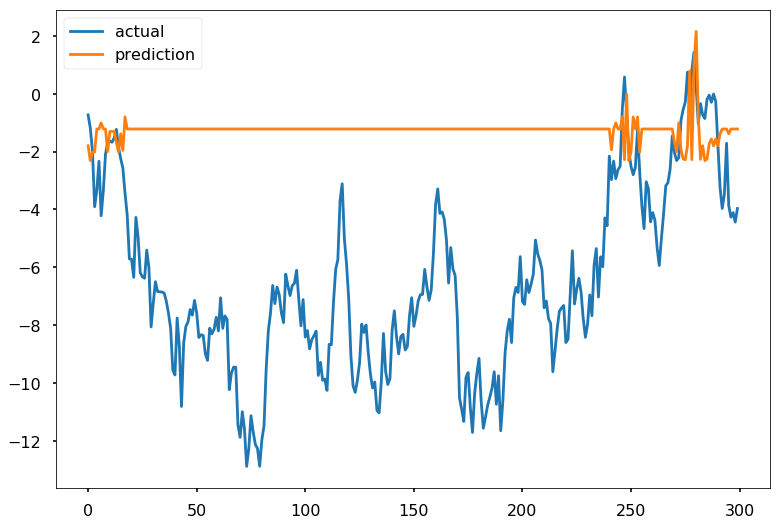

In [27]:
matrix = trajectory_matrix(df_wn['series1'], 700)

X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                    matrix[:,-1:], 
                                                    test_size=300, 
                                                    random_state=42,
                                                    shuffle=False
                                                   )

model_rf = RandomForestRegressor(n_estimators = 100)
model_rf.fit(X_train[:,-1:],y_train.reshape(-1,1))

train_prediction = model_rf.predict(X_train[:,-1:])
test_prediction = model_rf.predict(X_test[:,-1:])

mse_train = mean_squared_error(y_train, train_prediction)
mse_test = mean_squared_error(y_test, test_prediction)

print('Train MSE: {:.4f} Test MSE: {:.4f}'.format(round(mse_train,8),
                                          round(mse_test,8)))

plt.plot(y_test, label = 'actual')
plt.plot(test_prediction, label = 'prediction')
plt.legend()
plt.show()

Перейдем к разностям. Ошибку будем измерять на исходном ряде (то есть после прогноза возвращаемся к исходному ряду). Получилось отлично!

Train MSE: 0.4431 Test MSE: 0.9135


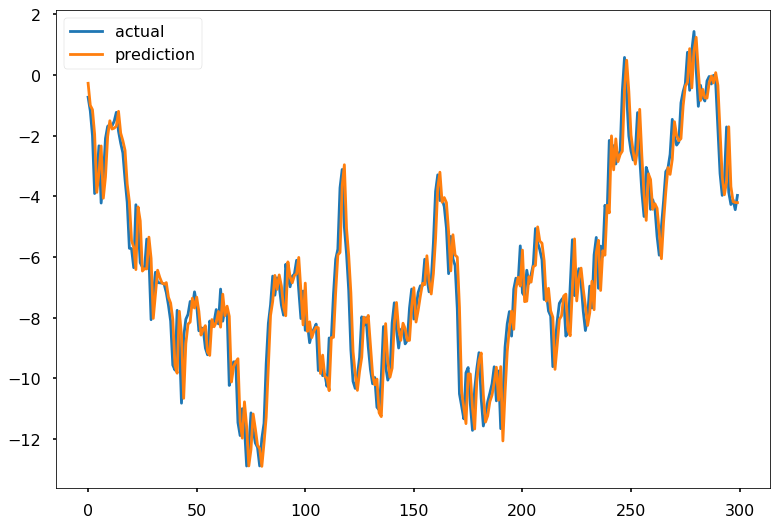

In [28]:
matrix = trajectory_matrix(np.diff(df_wn['series1']), 700)
matrix_non_diff = trajectory_matrix(df_wn['series1'], 700)

X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                    matrix[:,-1:], 
                                                    test_size=300, 
                                                    random_state=42,
                                                    shuffle=False
                                                   )

X_train_no_diff, X_test_no_diff, y_train_no_diff, y_test_no_diff  = train_test_split(matrix_non_diff[:,:-1],
                                                                                     matrix_non_diff[:,-1:],
                                                                                     test_size=300,
                                                                                     random_state=42,
                                                                                     shuffle=False
                                                                                    )


model_rf = RandomForestRegressor(max_depth = 5, n_estimators = 100)
model_rf.fit(X_train,y_train.reshape(-1,1))

train_prediction = X_train_no_diff[:,-1:] + model_rf.predict(X_train).reshape(-1,1)
test_prediction = X_test_no_diff[:,-1:] + model_rf.predict(X_test).reshape(-1,1)

mse_train = mean_squared_error(y_train_no_diff, train_prediction)
mse_test = mean_squared_error(y_test_no_diff, test_prediction)

print('Train MSE: {:.4f} Test MSE: {:.4f}'.format(round(mse_train,8),
                                          round(mse_test,8)))

plt.plot(y_test_no_diff, label = 'actual')
plt.plot(test_prediction, label = 'prediction')
plt.legend()
plt.show()

Посчитаем среднюю ошибку на всех рядах. Получилось немного хуже, чем в инсайт модели.

Average Train MSE: 0.4536 Average Test MSE: 1.0308 
Test Confidence interval = 0.0184


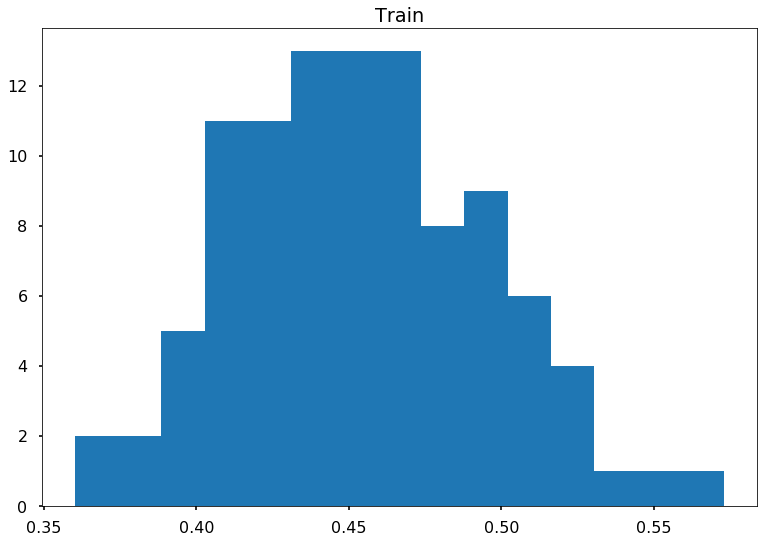

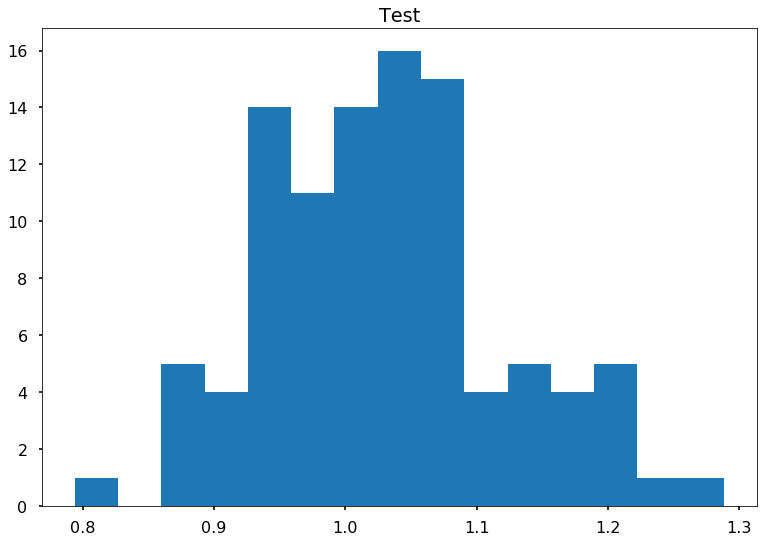

In [30]:
mse_train_list, mse_test_list = [], []

for i in range(1,101):
    matrix = trajectory_matrix(np.diff(df_wn['series' + str(i)]), 700)
    matrix_non_diff = trajectory_matrix(df_wn['series' + str(i)], 700)

    X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                        matrix[:,-1:], 
                                                        test_size=300, 
                                                        random_state=42,
                                                        shuffle=False
                                                       )

    X_train_no_diff, X_test_no_diff, y_train_no_diff, y_test_no_diff  = train_test_split(matrix_non_diff[:,:-1],
                                                                                         matrix_non_diff[:,-1:],
                                                                                         test_size=300,
                                                                                         random_state=42,
                                                                                         shuffle=False
                                                                                        )

    model_rf = RandomForestRegressor(max_depth = 5, n_estimators = 100)
    model_rf.fit(X_train,y_train.reshape(-1,1))

    train_prediction = X_train_no_diff[:,-1:] + model_rf.predict(X_train).reshape(-1,1)
    test_prediction = X_test_no_diff[:,-1:] + model_rf.predict(X_test).reshape(-1,1)

    mse_train = mean_squared_error(y_train_no_diff, train_prediction)
    mse_test = mean_squared_error(y_test_no_diff, test_prediction)
    
    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)


# print('Average train MSE for 100 series: {:.4f}'.format(np.mean(mse_train_list)))
# print('Average test MSE for 100 series: {:.4f}'.format(np.mean(mse_test_list)))

# print('Average Train MSE: {:.4f} Average Test MSE: {:.4f} \nTest 5% quantile = {:.4f} Test 95% quantile = {:.4f}'.format(
#     np.mean(mse_train_list),
#     np.mean(mse_test_list),
#     np.quantile(mse_test_list, 0.05),
#     np.quantile(mse_test_list, 0.95))
#      )

print('Average Train MSE: {:.4f} Average Test MSE: {:.4f} \nTest Confidence interval = {:.4f}'.format(np.mean(mse_train_list), np.mean(mse_test_list),
                                                                                   2*np.std(mse_test_list)/10))

plt.hist(mse_train_list, bins=15)
plt.title('Train')
plt.show()

plt.hist(mse_test_list, bins=15)
plt.title('Test')
plt.show()

df_results.loc['Brownian','Random forest Train'] = round(np.mean(mse_train_list),4)
df_results.loc['Brownian','Random forest Test'] = round(np.mean(mse_test_list),4)
df_results.loc['Brownian','Random forest Confidence interval'] = round(2*np.std(mse_test_list)/10,4)
# df_results.loc['Brownian','Random forest Test 5% quantile'] = round(np.quantile(mse_test_list, 0.05),4)
# df_results.loc['Brownian','Random forest Test 95% quantile'] = round(np.quantile(mse_test_list, 0.95),4)


Попробуем переход к разностям и брать только последний признак

Train MSE: 0.9055 Test MSE: 0.9259


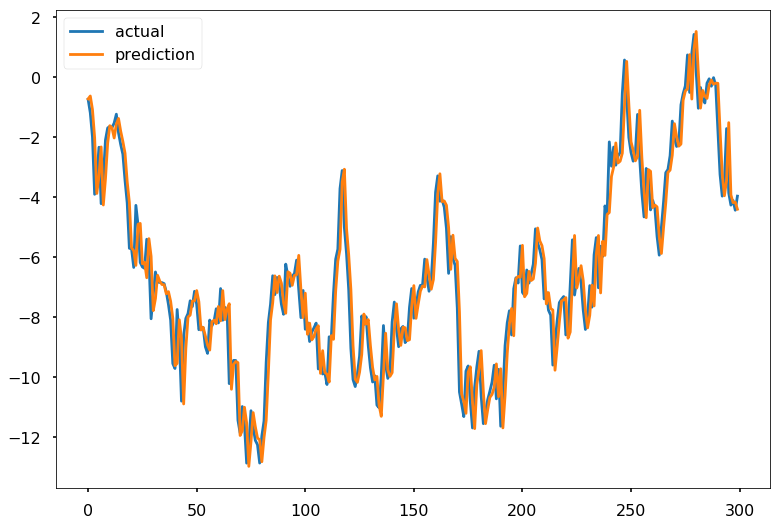

In [31]:
matrix = trajectory_matrix(np.diff(df_wn['series1']), 700)
matrix_non_diff = trajectory_matrix(df_wn['series1'], 700)

X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                    matrix[:,-1:], 
                                                    test_size=300, 
                                                    random_state=42,
                                                    shuffle=False
                                                   )

X_train_no_diff, X_test_no_diff, y_train_no_diff, y_test_no_diff  = train_test_split(matrix_non_diff[:,:-1],
                                                                                     matrix_non_diff[:,-1:],
                                                                                     test_size=300,
                                                                                     random_state=42,
                                                                                     shuffle=False
                                                                                    )


model_rf = RandomForestRegressor(max_depth = 5, n_estimators = 100)
model_rf.fit(X_train[:,-1:],y_train.reshape(-1,1))

train_prediction = X_train_no_diff[:,-1:] + model_rf.predict(X_train[:,-1:]).reshape(-1,1)
test_prediction = X_test_no_diff[:,-1:] + model_rf.predict(X_test[:,-1:]).reshape(-1,1)

mse_train = mean_squared_error(y_train_no_diff, train_prediction)
mse_test = mean_squared_error(y_test_no_diff, test_prediction)

print('Train MSE: {:.4f} Test MSE: {:.4f}'.format(round(mse_train,8),
                                          round(mse_test,8)))

plt.plot(y_test_no_diff, label = 'actual')
plt.plot(test_prediction, label = 'prediction')
plt.legend()
plt.show()

Получилось немного хуже, но значительно быстрее.

Average Train MSE: 0.7789 Average Test MSE: 1.0668 
Test Confidence interval = 0.0206


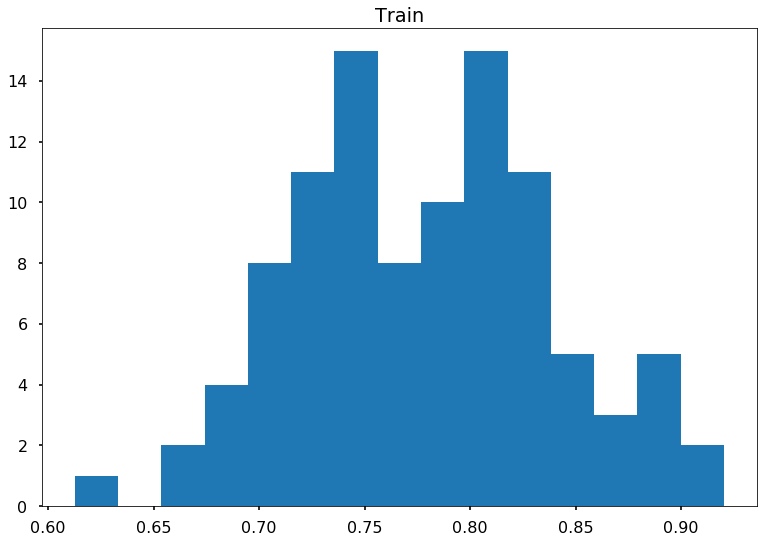

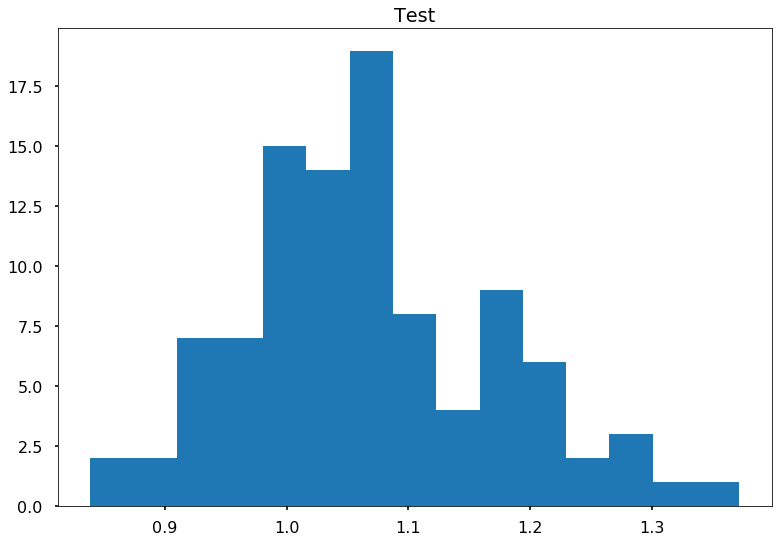

CPU times: user 27.6 s, sys: 20.1 s, total: 47.7 s
Wall time: 48.3 s


In [32]:
%%time
mse_train_list, mse_test_list = [], []

for i in range(1,101):
    matrix = trajectory_matrix(np.diff(df_wn['series' + str(i)]), 700)
    matrix_non_diff = trajectory_matrix(df_wn['series' + str(i)], 700)

    X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                        matrix[:,-1:], 
                                                        test_size=300, 
                                                        random_state=42,
                                                        shuffle=False
                                                       )

    X_train_no_diff, X_test_no_diff, y_train_no_diff, y_test_no_diff  = train_test_split(matrix_non_diff[:,:-1],
                                                                                         matrix_non_diff[:,-1:],
                                                                                         test_size=300,
                                                                                         random_state=42,
                                                                                         shuffle=False
                                                                                        )

    model_rf = RandomForestRegressor(max_depth = 5, n_estimators = 100)
    model_rf.fit(X_train[:,-1:],y_train.reshape(-1,1))

    train_prediction = X_train_no_diff[:,-1:] + model_rf.predict(X_train[:,-1:]).reshape(-1,1)
    test_prediction = X_test_no_diff[:,-1:] + model_rf.predict(X_test[:,-1:]).reshape(-1,1)

    mse_train = mean_squared_error(y_train_no_diff, train_prediction)
    mse_test = mean_squared_error(y_test_no_diff, test_prediction)
    
    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)


# print('Average train MSE for 100 series: {:.4f}'.format(np.mean(mse_train_list)))
# print('Average test MSE for 100 series: {:.4f}'.format(np.mean(mse_test_list)))

# print('Average Train MSE: {:.4f} Average Test MSE: {:.4f} \nTest 5% quantile = {:.4f} Test 95% quantile = {:.4f}'.format(
#     np.mean(mse_train_list),
#     np.mean(mse_test_list),
#     np.quantile(mse_test_list, 0.05),
#     np.quantile(mse_test_list, 0.95))
#      )

print('Average Train MSE: {:.4f} Average Test MSE: {:.4f} \nTest Confidence interval = {:.4f}'.format(np.mean(mse_train_list), np.mean(mse_test_list),
                                                                                   2*np.std(mse_test_list)/10))


plt.hist(mse_train_list, bins=15)
plt.title('Train')
plt.show()

plt.hist(mse_test_list, bins=15)
plt.title('Test')
plt.show()

Делаем вывод, что random forest подходит для прогнозирования броуновского движения. Но для этого обязательно нужно переходить к разностям.

### Линейный тренд

"В лоб" random forest прогнозирует константу не в пределах обучающей выборки.

Train MSE: 0.0026 Test MSE: 134.1185


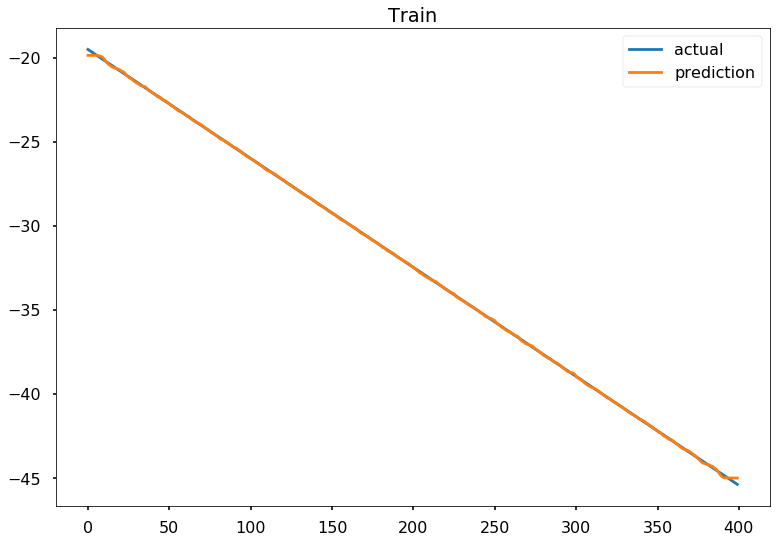

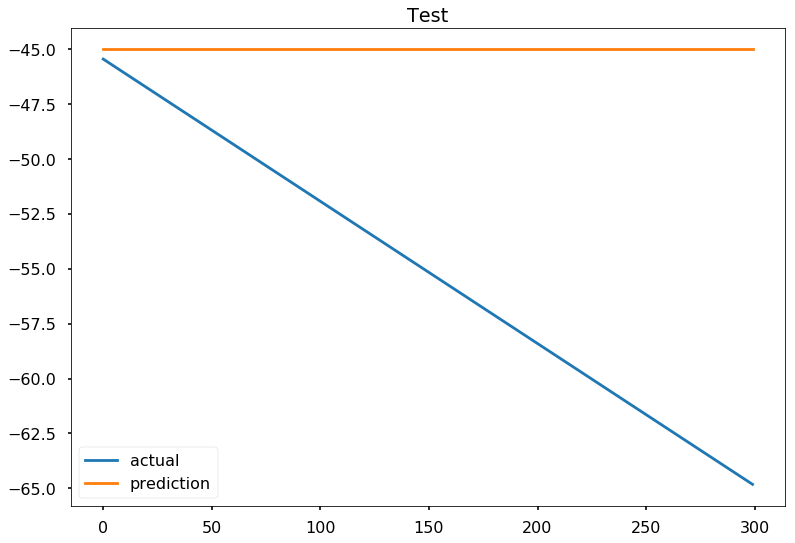

In [33]:
matrix = trajectory_matrix(df_lt['series1'], 700)

X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                    matrix[:,-1:], 
                                                    test_size=300, 
                                                    random_state=42,
                                                    shuffle=False
                                                   )

model_rf = RandomForestRegressor(max_depth = 5, n_estimators = 100)
model_rf.fit(X_train,y_train.reshape(-1,1))

train_prediction = model_rf.predict(X_train)
test_prediction = model_rf.predict(X_test)

mse_train = mean_squared_error(y_train, train_prediction)
mse_test = mean_squared_error(y_test, test_prediction)

print('Train MSE: {:.4f} Test MSE: {:.4f}'.format(round(mse_train,8),
                                          round(mse_test,8)))

plt.plot(y_train, label = 'actual')
plt.plot(train_prediction, label = 'prediction')
plt.legend()
plt.title('Train')
plt.show()

plt.plot(y_test, label = 'actual')
plt.plot(test_prediction, label = 'prediction')
plt.legend()
plt.title('Test')
plt.show()

Перейдем к разностям. При переходе к разностям ошибка на тренировочнои и на тестовом = 0.

Train MSE: 0.0000 Test MSE: 0.0000


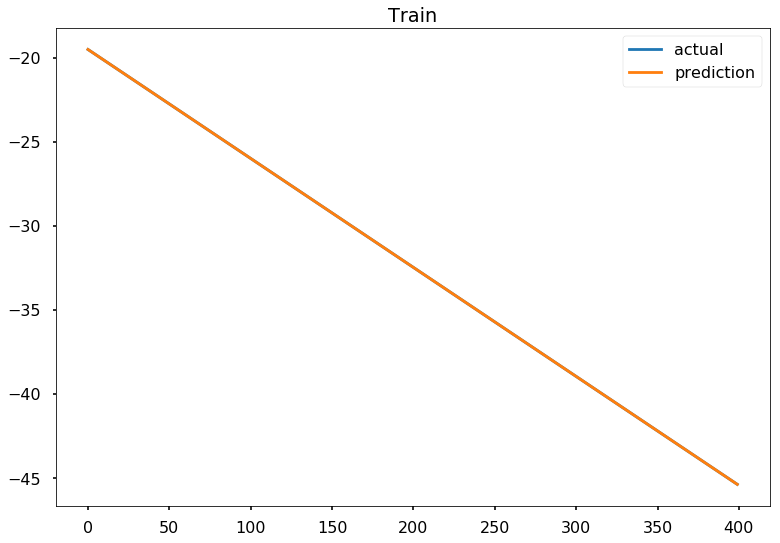

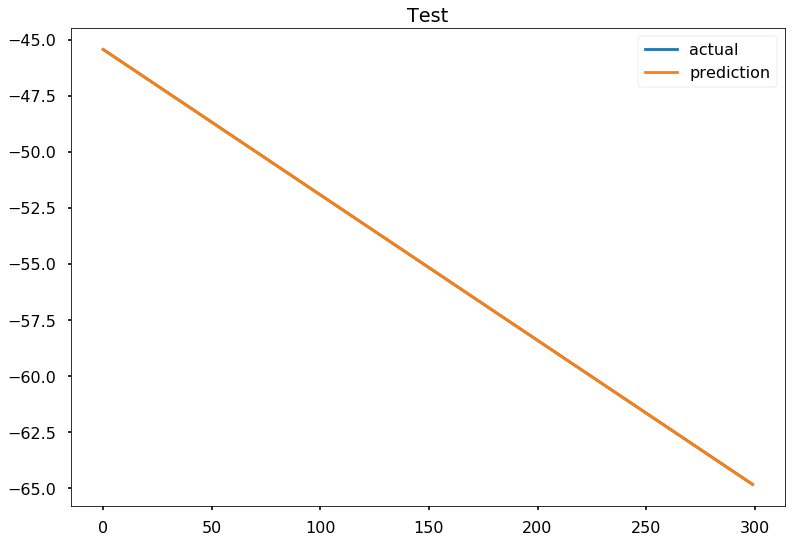

In [34]:
matrix = trajectory_matrix(np.diff(df_lt['series1']), 700)
matrix_non_diff = trajectory_matrix(df_lt['series1'], 700)

X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                    matrix[:,-1:], 
                                                    test_size=300, 
                                                    random_state=42,
                                                    shuffle=False
                                                   )

X_train_no_diff, X_test_no_diff, y_train_no_diff, y_test_no_diff  = train_test_split(matrix_non_diff[:,:-1],
                                                                                     matrix_non_diff[:,-1:],
                                                                                     test_size=300,
                                                                                     random_state=42,
                                                                                     shuffle=False
                                                                                    )


model_rf = RandomForestRegressor(max_depth = 5, n_estimators = 100)
model_rf.fit(X_train,y_train.reshape(-1,1))

train_prediction = X_train_no_diff[:,-1:] + model_rf.predict(X_train).reshape(-1,1)
test_prediction = X_test_no_diff[:,-1:] + model_rf.predict(X_test).reshape(-1,1)

mse_train = mean_squared_error(y_train_no_diff, train_prediction)
mse_test = mean_squared_error(y_test_no_diff, test_prediction)

print('Train MSE: {:.4f} Test MSE: {:.4f}'.format(round(mse_train,8),
                                          round(mse_test,8)))

plt.plot(y_train_no_diff, label = 'actual')
plt.plot(train_prediction, label = 'prediction')
plt.legend()
plt.title('Train')
plt.show()

plt.plot(y_test_no_diff, label = 'actual')
plt.plot(test_prediction, label = 'prediction')
plt.legend()
plt.title('Test')
plt.show()

Можем ограничиться только последним признаком - на результат это не повлияет.

Train MSE: 0.0000 Test MSE: 0.0000


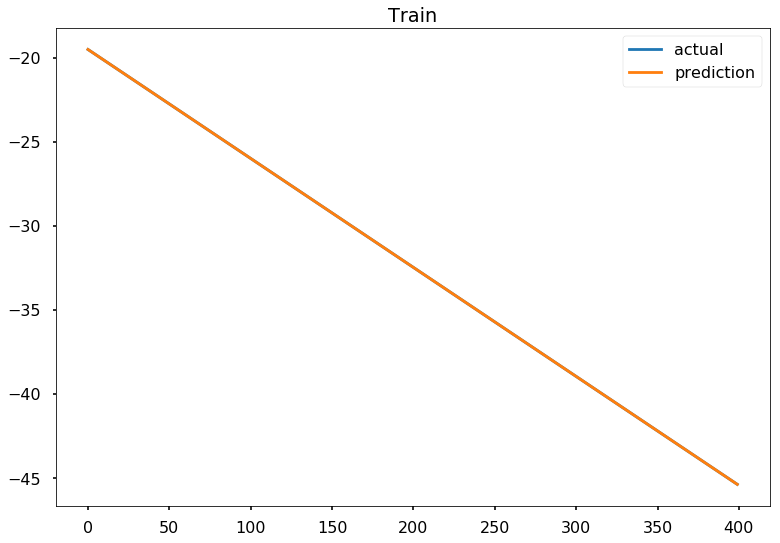

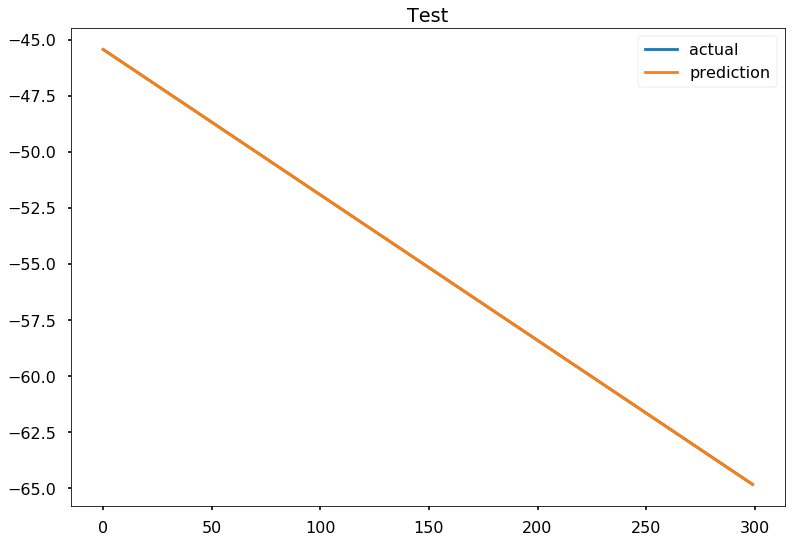

In [42]:
matrix = trajectory_matrix(np.diff(df_lt['series1']), 700)
matrix_non_diff = trajectory_matrix(df_lt['series1'], 700)

X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                    matrix[:,-1:], 
                                                    test_size=300, 
                                                    random_state=42,
                                                    shuffle=False
                                                   )

X_train_no_diff, X_test_no_diff, y_train_no_diff, y_test_no_diff  = train_test_split(matrix_non_diff[:,:-1],
                                                                                     matrix_non_diff[:,-1:],
                                                                                     test_size=300,
                                                                                     random_state=42,
                                                                                     shuffle=False
                                                                                    )


model_rf = RandomForestRegressor(max_depth = 5, n_estimators = 100)
model_rf.fit(X_train[:,-1:],y_train.reshape(-1,1))

train_prediction = X_train_no_diff[:,-1:] + model_rf.predict(X_train[:,-1:]).reshape(-1,1)
test_prediction = X_test_no_diff[:,-1:] + model_rf.predict(X_test[:,-1:]).reshape(-1,1)

mse_train = mean_squared_error(y_train_no_diff, train_prediction)
mse_test = mean_squared_error(y_test_no_diff, test_prediction)

print('Train MSE: {:.4f} Test MSE: {:.4f}'.format(round(mse_train,8),
                                          round(mse_test,8)))

plt.plot(y_train_no_diff, label = 'actual')
plt.plot(train_prediction, label = 'prediction')
plt.legend()
plt.title('Train')
plt.show()

plt.plot(y_test_no_diff, label = 'actual')
plt.plot(test_prediction, label = 'prediction')
plt.legend()
plt.title('Test')
plt.show()



df_results.loc['Linear trend','Random forest Train'] = 0
df_results.loc['Linear trend','Random forest Test'] = 0

# df_results.loc['Linear trend','Random forest Test 5% quantile'] = 0
# df_results.loc['Linear trend','Random forest Test 95% quantile'] = 0

Делаем вывод, random forest можно использовать для прогнозирования линейного тренда. Опять же, если изначально перейти к разностям.

### Линейный тренд с броуновским движением

Переход к разностям на одном ряде дает практически такой же результат как инсайт модель.

Train MSE: 0.4974 Test MSE: 0.8748


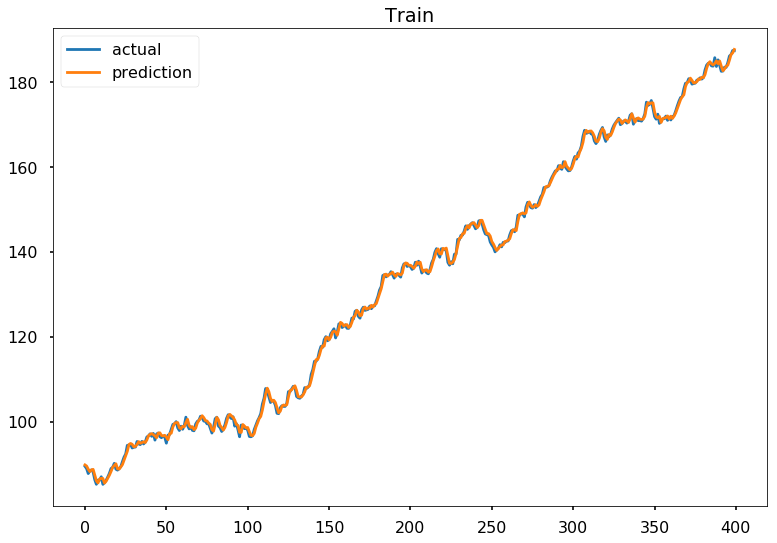

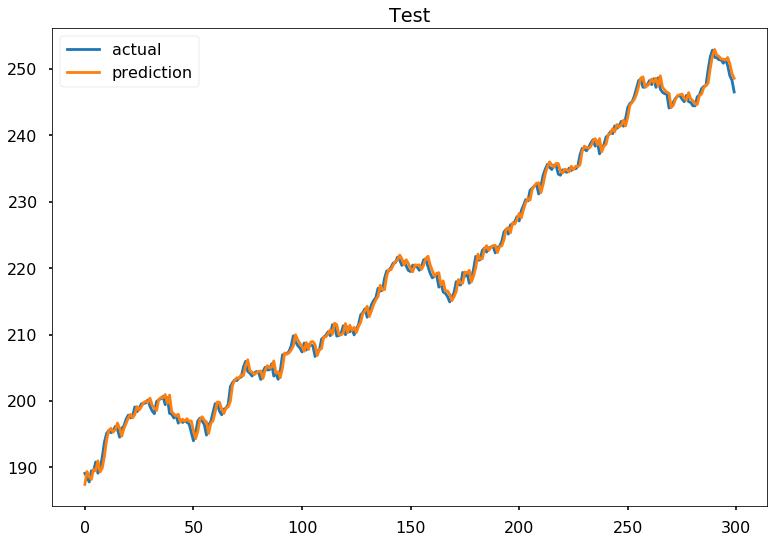

In [35]:
matrix = trajectory_matrix(np.diff(df_lt_wn['series1']), 700)
matrix_non_diff = trajectory_matrix(df_lt_wn['series1'], 700)

X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                    matrix[:,-1:], 
                                                    test_size=300, 
                                                    random_state=42,
                                                    shuffle=False
                                                   )

X_train_no_diff, X_test_no_diff, y_train_no_diff, y_test_no_diff  = train_test_split(matrix_non_diff[:,:-1],
                                                                                     matrix_non_diff[:,-1:],
                                                                                     test_size=300,
                                                                                     random_state=42,
                                                                                     shuffle=False
                                                                                    )


model_rf = RandomForestRegressor(max_depth = 5, n_estimators = 100)
model_rf.fit(X_train,y_train.reshape(-1,1))

train_prediction = X_train_no_diff[:,-1:] + model_rf.predict(X_train).reshape(-1,1)
test_prediction = X_test_no_diff[:,-1:] + model_rf.predict(X_test).reshape(-1,1)

mse_train = mean_squared_error(y_train_no_diff, train_prediction)
mse_test = mean_squared_error(y_test_no_diff, test_prediction)

print('Train MSE: {:.4f} Test MSE: {:.4f}'.format(round(mse_train,8),
                                          round(mse_test,8)))

plt.plot(y_train_no_diff, label = 'actual')
plt.plot(train_prediction, label = 'prediction')
plt.legend()
plt.title('Train')
plt.show()

plt.plot(y_test_no_diff, label = 'actual')
plt.plot(test_prediction, label = 'prediction')
plt.legend()
plt.title('Test')
plt.show()

Посчитаем среднюю ошибку на всех рядах. Получилось 1.03 vs 1.02

Average Train MSE: 0.4642 Average Test MSE: 1.0288 
Test Confidence interval = 0.0179


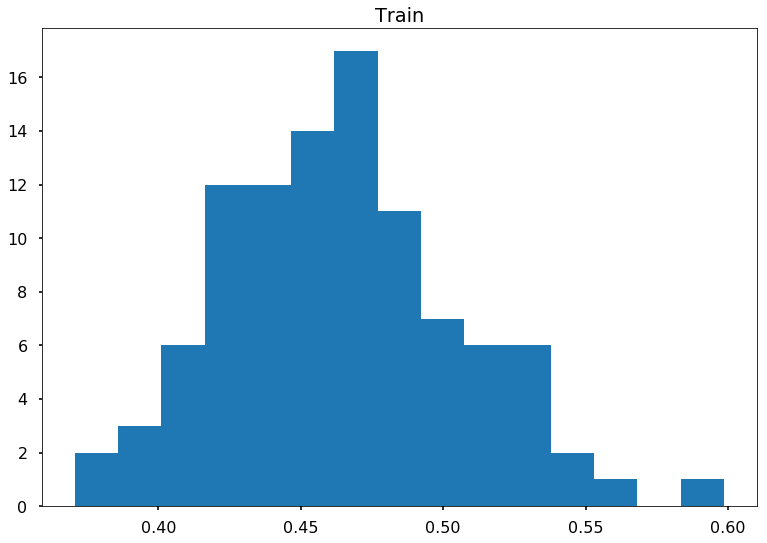

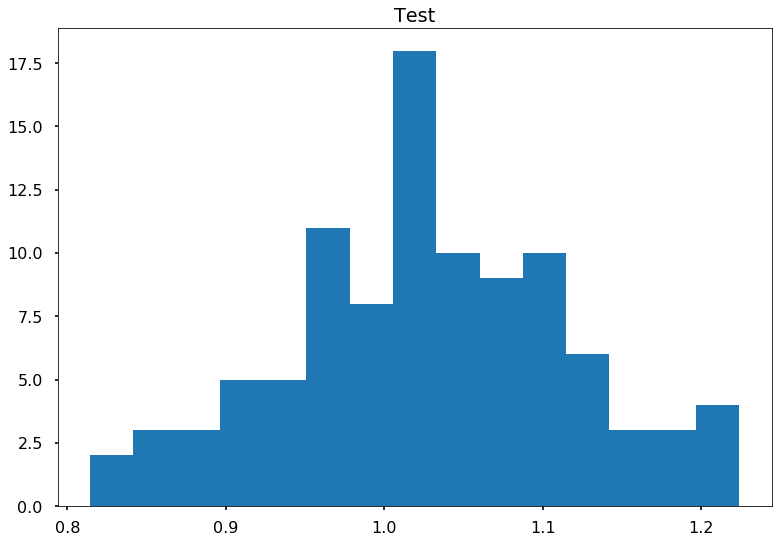

In [36]:
mse_train_list, mse_test_list = [], []

for i in range(1,101):
    matrix = trajectory_matrix(np.diff(df_lt_wn['series' + str(i)]), 700)
    matrix_non_diff = trajectory_matrix(df_lt_wn['series' + str(i)], 700)

    X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                        matrix[:,-1:], 
                                                        test_size=300, 
                                                        random_state=42,
                                                        shuffle=False
                                                       )

    X_train_no_diff, X_test_no_diff, y_train_no_diff, y_test_no_diff  = train_test_split(matrix_non_diff[:,:-1],
                                                                                         matrix_non_diff[:,-1:],
                                                                                         test_size=300,
                                                                                         random_state=42,
                                                                                         shuffle=False
                                                                                        )

    model_rf = RandomForestRegressor(max_depth = 5, n_estimators = 100)
    model_rf.fit(X_train,y_train.reshape(-1,1))

    train_prediction = X_train_no_diff[:,-1:] + model_rf.predict(X_train).reshape(-1,1)
    test_prediction = X_test_no_diff[:,-1:] + model_rf.predict(X_test).reshape(-1,1)

    mse_train = mean_squared_error(y_train_no_diff, train_prediction)
    mse_test = mean_squared_error(y_test_no_diff, test_prediction)
    
    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)


# print('Average train MSE for 100 series: {:.4f}'.format(np.mean(mse_train_list)))
# print('Average test MSE for 100 series: {:.4f}'.format(np.mean(mse_test_list)))

# print('Average Train MSE: {:.4f} Average Test MSE: {:.4f} \nTest 5% quantile = {:.4f} Test 95% quantile = {:.4f}'.format(
#     np.mean(mse_train_list),
#     np.mean(mse_test_list),
#     np.quantile(mse_test_list, 0.05),
#     np.quantile(mse_test_list, 0.95))
#      )

print('Average Train MSE: {:.4f} Average Test MSE: {:.4f} \nTest Confidence interval = {:.4f}'.format(np.mean(mse_train_list), np.mean(mse_test_list),
                                                                                   2*np.std(mse_test_list)/10))


plt.hist(mse_train_list, bins=15)
plt.title('Train')
plt.show()

plt.hist(mse_test_list, bins=15)
plt.title('Test')
plt.show()

df_results.loc['Linear trend + Brownian','Random forest Train'] = round(np.mean(mse_train_list),4)
df_results.loc['Linear trend + Brownian','Random forest Test'] = round(np.mean(mse_test_list),4)
df_results.loc['Linear trend + Brownian','Random forest Confidence interval'] = round(2*np.std(mse_test_list)/10,4)
# df_results.loc['Linear trend + Brownian','Random forest Test 5% quantile'] = round(np.quantile(mse_test_list, 0.05),4)
# df_results.loc['Linear trend + Brownian','Random forest Test 95% quantile'] = round(np.quantile(mse_test_list, 0.95),4)

Попробуем только на последнем признаке

Average Train MSE: 0.7945 Average Test MSE: 1.0631 
Test Confidence interval = 0.0181


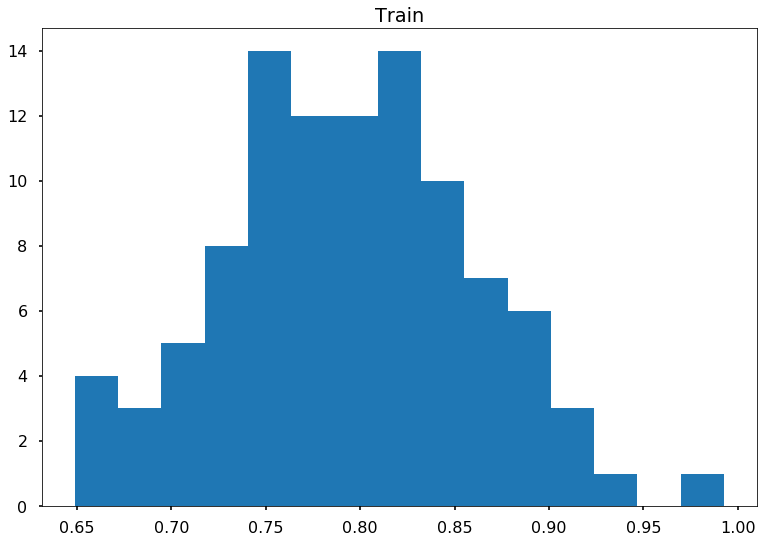

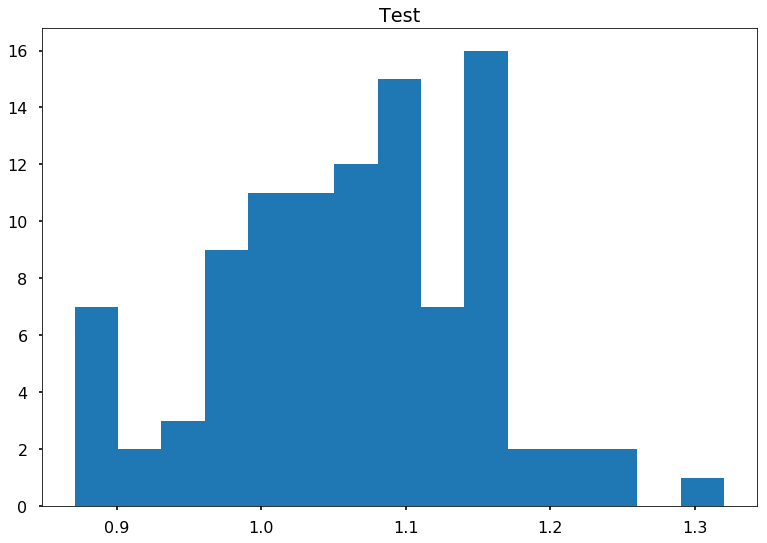

In [37]:
mse_train_list, mse_test_list = [], []

for i in range(1,101):
    matrix = trajectory_matrix(np.diff(df_lt_wn['series' + str(i)]), 700)
    matrix_non_diff = trajectory_matrix(df_lt_wn['series' + str(i)], 700)

    X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                        matrix[:,-1:], 
                                                        test_size=300, 
                                                        random_state=42,
                                                        shuffle=False
                                                       )

    X_train_no_diff, X_test_no_diff, y_train_no_diff, y_test_no_diff  = train_test_split(matrix_non_diff[:,:-1],
                                                                                         matrix_non_diff[:,-1:],
                                                                                         test_size=300,
                                                                                         random_state=42,
                                                                                         shuffle=False
                                                                                        )

    model_rf = RandomForestRegressor(max_depth = 5, n_estimators = 100)
    model_rf.fit(X_train[:,-1:],y_train.reshape(-1,1))

    train_prediction = X_train_no_diff[:,-1:] + model_rf.predict(X_train[:,-1:]).reshape(-1,1)
    test_prediction = X_test_no_diff[:,-1:] + model_rf.predict(X_test[:,-1:]).reshape(-1,1)

    mse_train = mean_squared_error(y_train_no_diff, train_prediction)
    mse_test = mean_squared_error(y_test_no_diff, test_prediction)
    
    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)


# print('Average train MSE for 100 series: {:.4f}'.format(np.mean(mse_train_list)))
# print('Average test MSE for 100 series: {:.4f}'.format(np.mean(mse_test_list)))

# print('Average Train MSE: {:.4f} Average Test MSE: {:.4f} \nTest 5% quantile = {:.4f} Test 95% quantile = {:.4f}'.format(
#     np.mean(mse_train_list),
#     np.mean(mse_test_list),
#     np.quantile(mse_test_list, 0.05),
#     np.quantile(mse_test_list, 0.95))
#      )

print('Average Train MSE: {:.4f} Average Test MSE: {:.4f} \nTest Confidence interval = {:.4f}'.format(np.mean(mse_train_list), np.mean(mse_test_list),
                                                                                   2*np.std(mse_test_list)/10))


plt.hist(mse_train_list, bins=15)
plt.title('Train')
plt.show()

plt.hist(mse_test_list, bins=15)
plt.title('Test')
plt.show()

### Линейный тренд с изломами

На одном ряду получилось лучше, чем по инсайт модели

Train MSE: 0.0017 Test MSE: 0.0741


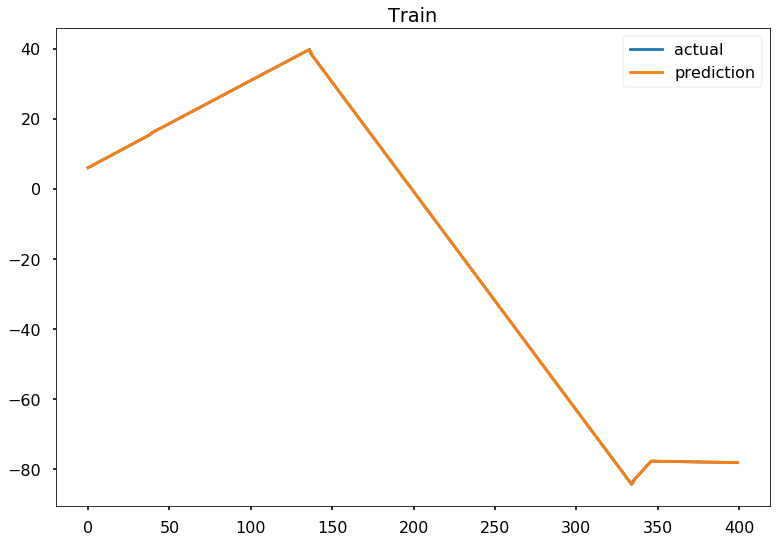

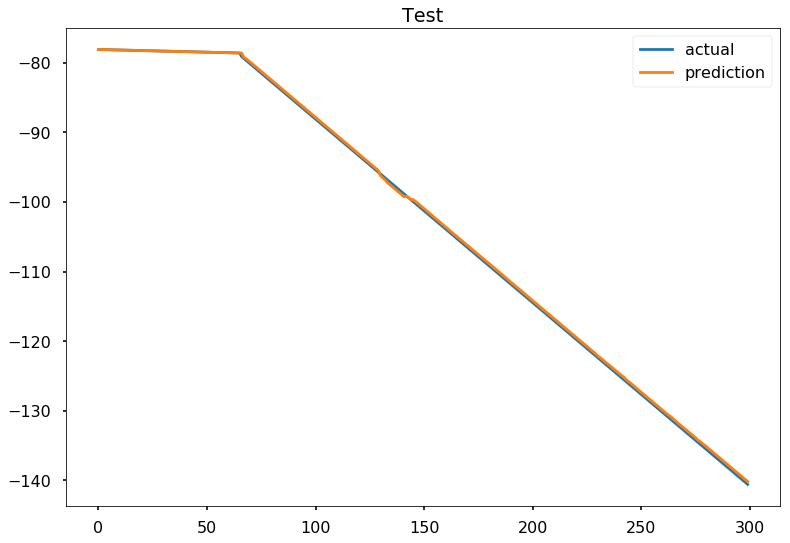

In [38]:
matrix = trajectory_matrix(np.diff(df_lt_d['series1']), 700)
matrix_non_diff = trajectory_matrix(df_lt_d['series1'], 700)

X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                    matrix[:,-1:], 
                                                    test_size=300, 
                                                    random_state=42,
                                                    shuffle=False
                                                   )

X_train_no_diff, X_test_no_diff, y_train_no_diff, y_test_no_diff  = train_test_split(matrix_non_diff[:,:-1],
                                                                                     matrix_non_diff[:,-1:],
                                                                                     test_size=300,
                                                                                     random_state=42,
                                                                                     shuffle=False
                                                                                    )


model_rf = RandomForestRegressor(max_depth = 5, n_estimators = 100)
model_rf.fit(X_train,y_train.reshape(-1,1))

train_prediction = X_train_no_diff[:,-1:] + model_rf.predict(X_train).reshape(-1,1)
test_prediction = X_test_no_diff[:,-1:] + model_rf.predict(X_test).reshape(-1,1)

mse_train = mean_squared_error(y_train_no_diff, train_prediction)
mse_test = mean_squared_error(y_test_no_diff, test_prediction)

print('Train MSE: {:.4f} Test MSE: {:.4f}'.format(round(mse_train,8),
                                          round(mse_test,8)))

plt.plot(y_train_no_diff, label = 'actual')
plt.plot(train_prediction, label = 'prediction')
plt.legend()
plt.title('Train')
plt.show()

plt.plot(y_test_no_diff, label = 'actual')
plt.plot(test_prediction, label = 'prediction')
plt.legend()
plt.title('Test')
plt.show()

Посчитаем среднюю ошибку на всех рядах. Получилось хуже инсайт модели (0.08 vs 0.20).

Average Train MSE: 0.0024 Average Test MSE: 0.1988 
Test Confidence interval = 0.0617


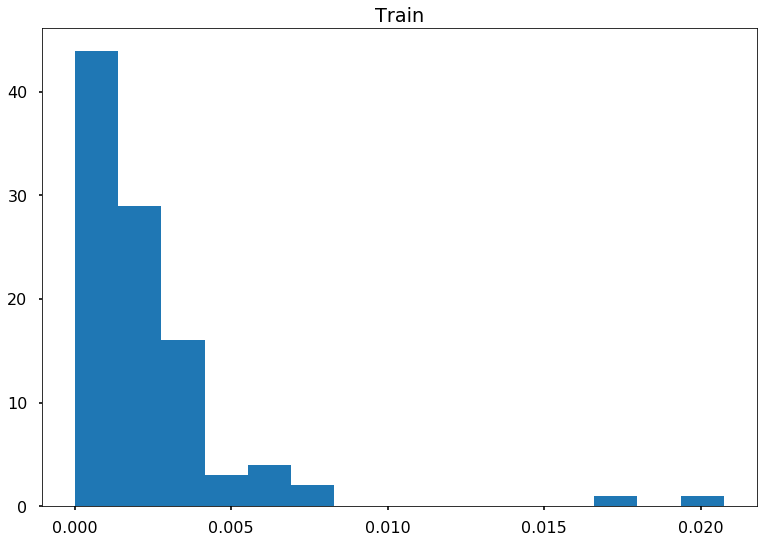

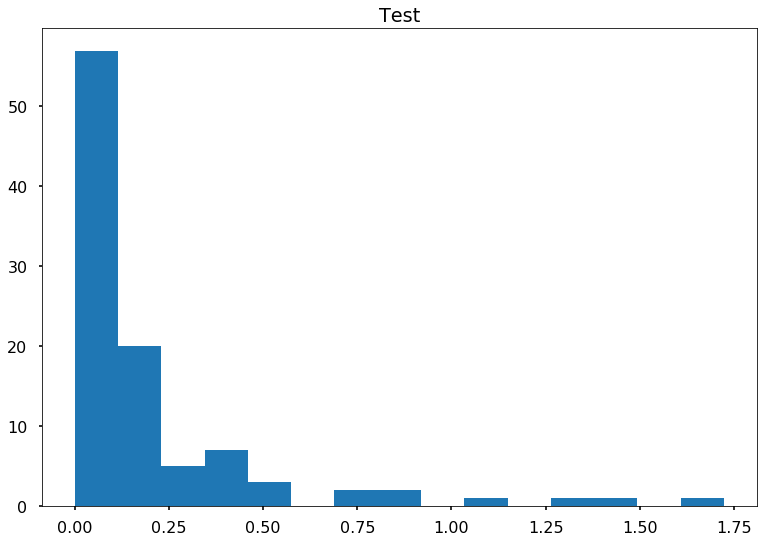

In [39]:
mse_train_list, mse_test_list = [], []

for i in range(1,101):
    matrix = trajectory_matrix(np.diff(df_lt_d['series' + str(i)]), 700)
    matrix_non_diff = trajectory_matrix(df_lt_d['series' + str(i)], 700)

    X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                        matrix[:,-1:], 
                                                        test_size=300, 
                                                        random_state=42,
                                                        shuffle=False
                                                       )

    X_train_no_diff, X_test_no_diff, y_train_no_diff, y_test_no_diff  = train_test_split(matrix_non_diff[:,:-1],
                                                                                         matrix_non_diff[:,-1:],
                                                                                         test_size=300,
                                                                                         random_state=42,
                                                                                         shuffle=False
                                                                                        )

    model_rf = RandomForestRegressor(max_depth = 5, n_estimators = 100)
    model_rf.fit(X_train,y_train.reshape(-1,1))

    train_prediction = X_train_no_diff[:,-1:] + model_rf.predict(X_train).reshape(-1,1)
    test_prediction = X_test_no_diff[:,-1:] + model_rf.predict(X_test).reshape(-1,1)

    mse_train = mean_squared_error(y_train_no_diff, train_prediction)
    mse_test = mean_squared_error(y_test_no_diff, test_prediction)
    
    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)


# print('Average train MSE for 100 series: {:.4f}'.format(np.mean(mse_train_list)))
# print('Average test MSE for 100 series: {:.4f}'.format(np.mean(mse_test_list)))

# print('Average Train MSE: {:.4f} Average Test MSE: {:.4f} \nTest 5% quantile = {:.4f} Test 95% quantile = {:.4f}'.format(
#     np.mean(mse_train_list),
#     np.mean(mse_test_list),
#     np.quantile(mse_test_list, 0.05),
#     np.quantile(mse_test_list, 0.95))
#      )

print('Average Train MSE: {:.4f} Average Test MSE: {:.4f} \nTest Confidence interval = {:.4f}'.format(np.mean(mse_train_list), np.mean(mse_test_list),
                                                                                   2*np.std(mse_test_list)/10))


plt.hist(mse_train_list, bins=15)
plt.title('Train')
plt.show()

plt.hist(mse_test_list, bins=15)
plt.title('Test')
plt.show()

Однако в инсайт модели мы изначально оценивали оптимальную длину, а уже потом обучали модель. Попробуем оценить длину окна для Random forest

Optimal k is 22


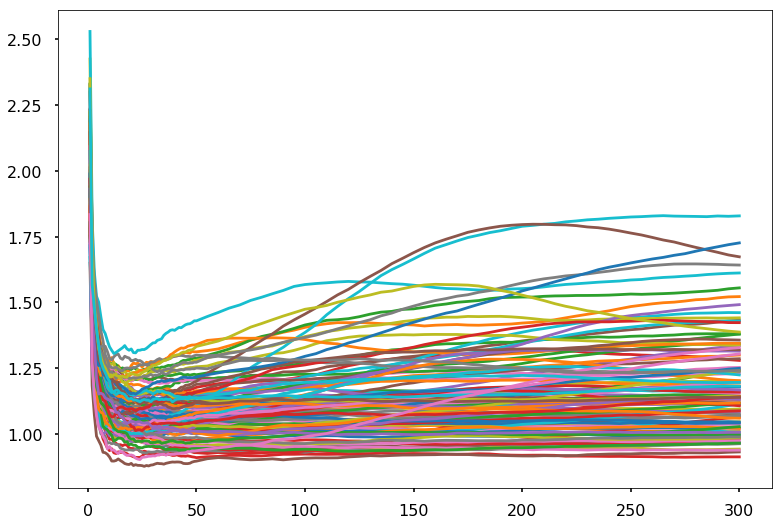

In [40]:
mse_list_all = []


for i in range(1,101):
    mse_list = []
    matrix = trajectory_matrix(df_lt_d_wn['series' + str(i)], 700)

    X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                        matrix[:,-1:], 
                                                        test_size=300, 
                                                        random_state=42,
                                                        shuffle=False
                                                       )
    for k in k_list:
        insight_prediction = X_train[:,-1:] + np.mean(np.diff(X_train)[:,-k:], axis=1).reshape(-1,1)
        mse_list.append(mean_squared_error(y_train, insight_prediction))
        
    mse_list_all.append(mse_list)

k_optimals = get_k_optimals(k_list, mse_list_all)

print('Optimal k is {}'.format(max(set(k_optimals), key = k_optimals.count)))

for pl in mse_list_all:
    plt.plot(k_list, pl)
plt.show()

Optimal train k is 300
Optimal test k is 1


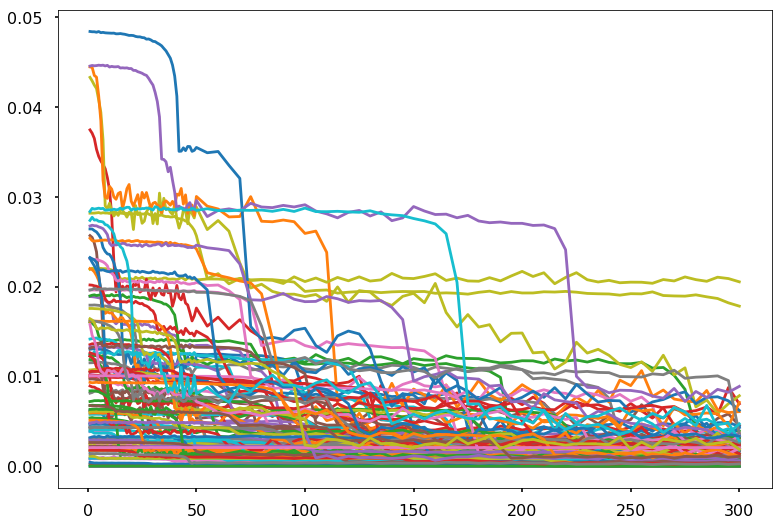

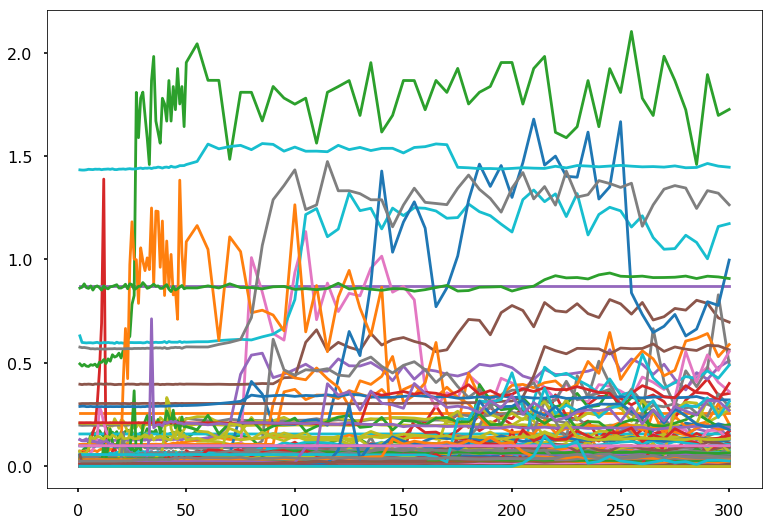

CPU times: user 19min 55s, sys: 20.8 s, total: 20min 16s
Wall time: 20min 21s


In [41]:
%%time
k_list = [i for i in range(1,50)]
k_list.extend([i for i in range(50, 301, 5)])
mse_train_all = []
mse_test_all = []


for i in range(1,101):
    mse_train_list, mse_test_list = [], []
    matrix = trajectory_matrix(np.diff(df_lt_d['series' + str(i)]), 700)
    matrix_non_diff = trajectory_matrix(df_lt_d['series' + str(i)], 700)

    X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                        matrix[:,-1:], 
                                                        test_size=300, 
                                                        random_state=42,
                                                        shuffle=False
                                                       )
    X_train_no_diff, X_test_no_diff, y_train_no_diff, y_test_no_diff  = train_test_split(matrix_non_diff[:,:-1],
                                                                                             matrix_non_diff[:,-1:],
                                                                                             test_size=300,
                                                                                             random_state=42,
                                                                                             shuffle=False
                                                                                            )
    for k in k_list:
        model_rf = RandomForestRegressor(max_depth = 5, n_estimators = 100)
        model_rf.fit(X_train[:,-k:],y_train.reshape(-1,1))

        train_prediction = X_train_no_diff[:,-1:] + model_rf.predict(X_train[:,-k:]).reshape(-1,1)
        test_prediction = X_test_no_diff[:,-1:] + model_rf.predict(X_test[:,-k:]).reshape(-1,1)

        mse_train = mean_squared_error(y_train_no_diff, train_prediction)
        mse_test = mean_squared_error(y_test_no_diff, test_prediction)

        mse_train_list.append(mse_train)
        mse_test_list.append(mse_test)
        
    mse_train_all.append(mse_train_list)
    mse_test_all.append(mse_test_list)

k_train_optimals = get_k_optimals(k_list, mse_train_all)
k_test_optimals = get_k_optimals(k_list, mse_test_all)

print('Optimal train k is {}'.format(max(set(k_train_optimals), key = k_train_optimals.count)))
print('Optimal test k is {}'.format(max(set(k_test_optimals), key = k_test_optimals.count)))

for pl in mse_train_all:
    plt.plot(k_list, pl)
plt.show()

for pl in mse_test_all:
    plt.plot(k_list, pl)
plt.show()

k получилось равно 1 (вероятно следует проверить не на 10 рядах, а на всех 100)

Действительно, если брать только последний признак, то результат получается очень близкий к инсайт модели. 0.08 vs 0.09

Average Train MSE: 0.0116 Average Test MSE: 0.0913 
Test Confidence interval = 0.0420


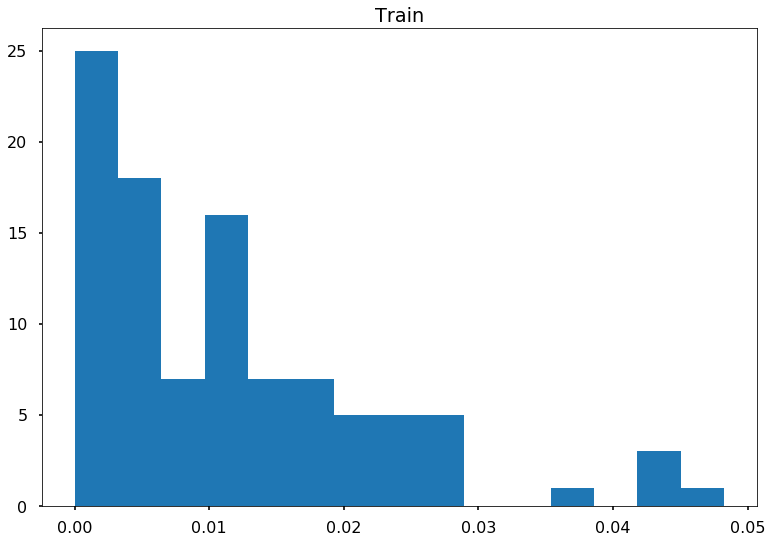

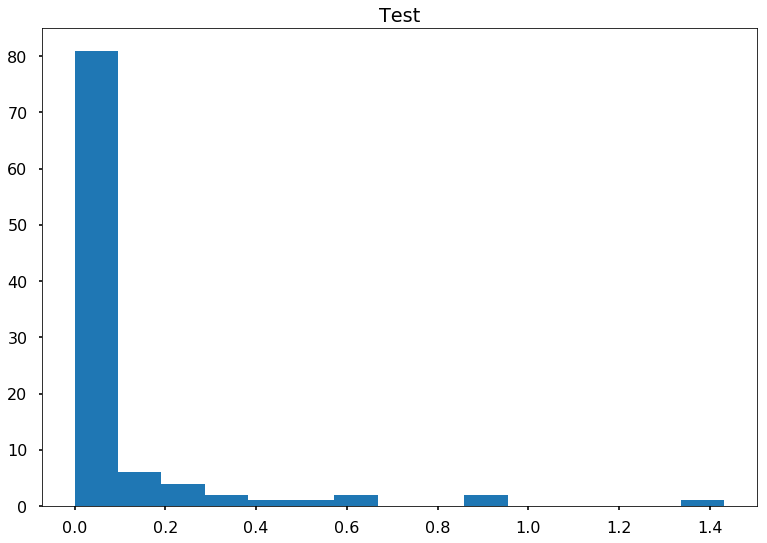

CPU times: user 24.1 s, sys: 18.1 s, total: 42.1 s
Wall time: 42.4 s


In [42]:
%%time
mse_train_list, mse_test_list = [], []

for i in range(1,101):
    matrix = trajectory_matrix(np.diff(df_lt_d['series' + str(i)]), 700)
    matrix_non_diff = trajectory_matrix(df_lt_d['series' + str(i)], 700)

    X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                        matrix[:,-1:], 
                                                        test_size=300, 
                                                        random_state=42,
                                                        shuffle=False
                                                       )

    X_train_no_diff, X_test_no_diff, y_train_no_diff, y_test_no_diff  = train_test_split(matrix_non_diff[:,:-1],
                                                                                         matrix_non_diff[:,-1:],
                                                                                         test_size=300,
                                                                                         random_state=42,
                                                                                         shuffle=False
                                                                                        )

    model_rf = RandomForestRegressor(max_depth = 5, n_estimators = 100)
    model_rf.fit(X_train[:,-1:],y_train.reshape(-1,1))

    train_prediction = X_train_no_diff[:,-1:] + model_rf.predict(X_train[:,-1:]).reshape(-1,1)
    test_prediction = X_test_no_diff[:,-1:] + model_rf.predict(X_test[:,-1:]).reshape(-1,1)

    mse_train = mean_squared_error(y_train_no_diff, train_prediction)
    mse_test = mean_squared_error(y_test_no_diff, test_prediction)
    
    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)


# print('Average train MSE for 100 series: {:.4f}'.format(np.mean(mse_train_list)))
# print('Average test MSE for 100 series: {:.4f}'.format(np.mean(mse_test_list)))

# print('Average Train MSE: {:.4f} Average Test MSE: {:.4f} \nTest 5% quantile = {:.4f} Test 95% quantile = {:.4f}'.format(
#     np.mean(mse_train_list),
#     np.mean(mse_test_list),
#     np.quantile(mse_test_list, 0.05),
#     np.quantile(mse_test_list, 0.95))
#      )

print('Average Train MSE: {:.4f} Average Test MSE: {:.4f} \nTest Confidence interval = {:.4f}'.format(np.mean(mse_train_list), np.mean(mse_test_list),
                                                                                   2*np.std(mse_test_list)/10))


plt.hist(mse_train_list, bins=15)
plt.title('Train')
plt.show()

plt.hist(mse_test_list, bins=15)
plt.title('Test')
plt.show()

df_results.loc['Linear trend + changes','Random forest Train'] = round(np.mean(mse_train_list),4)
df_results.loc['Linear trend + changes','Random forest Test'] = round(np.mean(mse_test_list),4)
df_results.loc['Linear trend + changes','Random forest Confidence interval'] = round(2*np.std(mse_test_list)/10,4)
# df_results.loc['Linear trend + changes','Random forest Test 5% quantile'] = round(np.quantile(mse_test_list, 0.05),4)
# df_results.loc['Linear trend + changes','Random forest Test 95% quantile'] = round(np.quantile(mse_test_list, 0.95),4)

### Линейный тренд с броуновским движением и с изломами

Посчитаем оптимальную длину окна

Optimal train k is 295
Optimal test k is 25


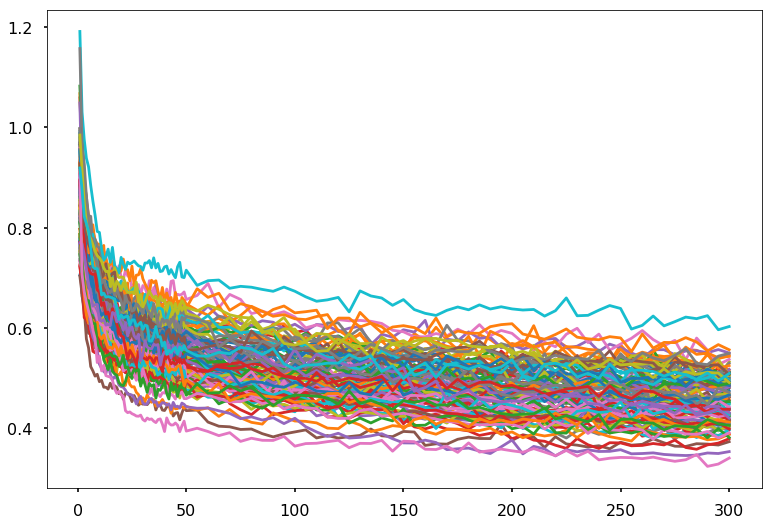

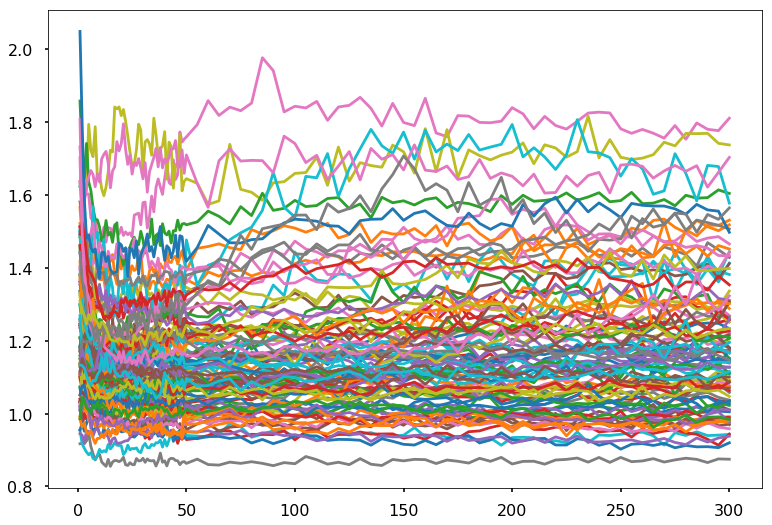

CPU times: user 2h 14min 31s, sys: 1min 1s, total: 2h 15min 32s
Wall time: 2h 24min 45s


In [51]:
%%time
k_list = [i for i in range(1,50)]
k_list.extend([i for i in range(50, 301, 5)])
mse_train_all = []
mse_test_all = []


for i in range(1,101):
    mse_train_list, mse_test_list = [], []
    matrix = trajectory_matrix(np.diff(df_lt_d_wn['series' + str(i)]), 700)
    matrix_non_diff = trajectory_matrix(df_lt_d_wn['series' + str(i)], 700)

    X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                        matrix[:,-1:], 
                                                        test_size=300, 
                                                        random_state=42,
                                                        shuffle=False
                                                       )
    X_train_no_diff, X_test_no_diff, y_train_no_diff, y_test_no_diff  = train_test_split(matrix_non_diff[:,:-1],
                                                                                             matrix_non_diff[:,-1:],
                                                                                             test_size=300,
                                                                                             random_state=42,
                                                                                             shuffle=False
                                                                                            )
    for k in k_list:
        model_rf = RandomForestRegressor(max_depth = 5, n_estimators = 100)
        model_rf.fit(X_train[:,-k:],y_train.reshape(-1,1))

        train_prediction = X_train_no_diff[:,-1:] + model_rf.predict(X_train[:,-k:]).reshape(-1,1)
        test_prediction = X_test_no_diff[:,-1:] + model_rf.predict(X_test[:,-k:]).reshape(-1,1)

        mse_train = mean_squared_error(y_train_no_diff, train_prediction)
        mse_test = mean_squared_error(y_test_no_diff, test_prediction)

        mse_train_list.append(mse_train)
        mse_test_list.append(mse_test)
        
    mse_train_all.append(mse_train_list)
    mse_test_all.append(mse_test_list)

k_train_optimals = get_k_optimals(k_list, mse_train_all)
k_test_optimals = get_k_optimals(k_list, mse_test_all)

print('Optimal train k is {}'.format(max(set(k_train_optimals), key = k_train_optimals.count)))
print('Optimal test k is {}'.format(max(set(k_test_optimals), key = k_test_optimals.count)))

for pl in mse_train_all:
    plt.plot(k_list, pl)
plt.show()

for pl in mse_test_all:
    plt.plot(k_list, pl)
plt.show()

Посчитаем среднюю ошибку на 100 рядах при длине окна = 50. Результат сопоставим инсайт методу.

Average Train MSE: 0.5822 Average Test MSE: 1.1424 
Test Confidence interval = 0.0300


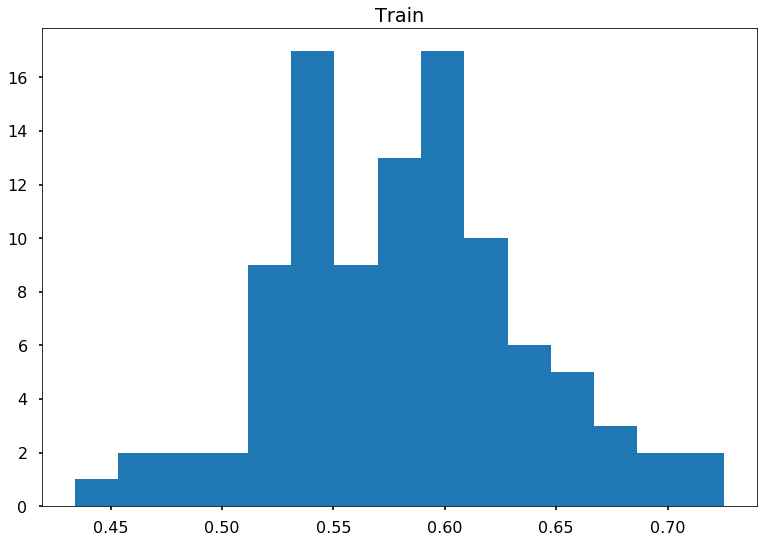

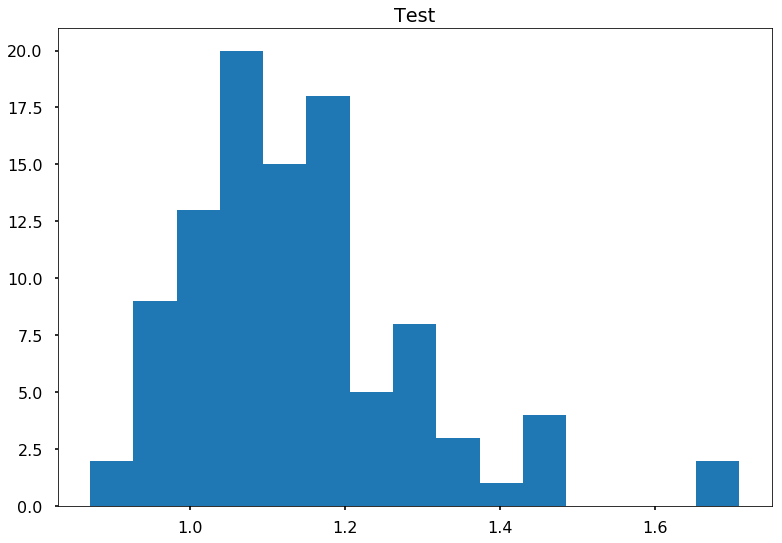

CPU times: user 43.4 s, sys: 18.7 s, total: 1min 2s
Wall time: 1min 2s


In [43]:
%%time
mse_train_list, mse_test_list = [], []
k = 25

for i in range(1,101):
#     k = k_train_optimals[i-1]
    matrix = trajectory_matrix(np.diff(df_lt_d_wn['series' + str(i)]), 700)
    matrix_non_diff = trajectory_matrix(df_lt_d_wn['series' + str(i)], 700)

    X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                        matrix[:,-1:], 
                                                        test_size=300, 
                                                        random_state=42,
                                                        shuffle=False
                                                       )

    X_train_no_diff, X_test_no_diff, y_train_no_diff, y_test_no_diff  = train_test_split(matrix_non_diff[:,:-1],
                                                                                         matrix_non_diff[:,-1:],
                                                                                         test_size=300,
                                                                                         random_state=42,
                                                                                         shuffle=False
                                                                                        )

    model_rf = RandomForestRegressor(max_depth = 5, n_estimators = 100)
    model_rf.fit(X_train[:,-k:],y_train.reshape(-1,1))

    train_prediction = X_train_no_diff[:,-1:] + model_rf.predict(X_train[:,-k:]).reshape(-1,1)
    test_prediction = X_test_no_diff[:,-1:] + model_rf.predict(X_test[:,-k:]).reshape(-1,1)

    mse_train = mean_squared_error(y_train_no_diff, train_prediction)
    mse_test = mean_squared_error(y_test_no_diff, test_prediction)
    
    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)


# print('Average train MSE for 100 series: {:.4f}'.format(np.mean(mse_train_list)))
# print('Average test MSE for 100 series: {:.4f}'.format(np.mean(mse_test_list)))

# print('Average Train MSE: {:.4f} Average Test MSE: {:.4f} \nTest 5% quantile = {:.4f} Test 95% quantile = {:.4f}'.format(
#     np.mean(mse_train_list),
#     np.mean(mse_test_list),
#     np.quantile(mse_test_list, 0.05),
#     np.quantile(mse_test_list, 0.95))
#      )

print('Average Train MSE: {:.4f} Average Test MSE: {:.4f} \nTest Confidence interval = {:.4f}'.format(np.mean(mse_train_list), np.mean(mse_test_list),
                                                                                   2*np.std(mse_test_list)/10))


plt.hist(mse_train_list, bins=15)
plt.title('Train')
plt.show()

plt.hist(mse_test_list, bins=15)
plt.title('Test')
plt.show()

df_results.loc['Linear trend + changes + Brownian','Random forest Train'] = round(np.mean(mse_train_list),4)
df_results.loc['Linear trend + changes + Brownian','Random forest Test'] = round(np.mean(mse_test_list),4)
df_results.loc['Linear trend + changes + Brownian','Random forest Confidence interval'] = round(2*np.std(mse_test_list)/10,4)
# df_results.loc['Linear trend + changes + Brownian','Random forest Test 5% quantile'] = round(np.quantile(mse_test_list, 0.05),4)
# df_results.loc['Linear trend + changes + Brownian','Random forest Test 95% quantile'] = round(np.quantile(mse_test_list, 0.95),4)


## Таблица с результатами

In [49]:
df_results

,Error low bound,Error high bound,Insight Test,Insight Test Confidence interval,Random forest Train,Random forest Test,Random forest Confidence interval
Brownian,1,1,1.0107,0.0179,0.4536,1.0308,0.0184
Linear trend,0,0.25,0,0,0,0,0
Linear trend + Brownian,1,1.25,1.0135,0.0176,0.4642,1.0288,0.0179
Linear trend + changes,0.0025,0.2525,0.0093,0.0024,0.0116,0.0913,0.042
Linear trend + changes + Brownian,1.0025,1.2525,1.0791,0.0197,0.5822,1.1424,0.03
